In [1]:
import ast
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# do not truncate the dataframe column width
pd.options.display.max_colwidth = None
pd.options.display.max_columns = None

sys.path.append('F:/repo/gpsbeam')

from src.data.dataprep import DataPrep
from src.config.data_config import DataConfig
from src.data.datatotensor import DataToTensor

# Categorize height and speed
def categorize_height(height):
    if height <= 40:
        return 'Low(≤40 m)'
    elif height <= 80:
        return 'Medium(40~80 m)'
    return 'High(>80 m)'

def categorize_speed(speed_mph):
    if speed_mph <= 10:
        return 'Slow(≤10 mph)'
    elif speed_mph <= 20:
        return 'Medium(10~20 mph)'
    return 'Fast(>20 mph)'

# Helper function to parse string arrays
def parse_array(x, col_name):
    if 'power' in col_name:
        return np.array([float(num) for num in x.strip('[]').split()])
    if 'tresh' in col_name:
        return np.array([int(num) for num in x.strip('[]').split()])
    return ast.literal_eval(x)

def process_beam_data(df):
    selected_col = ['input_speed', 'input_height', 'top5_preds', 'labels', 
                    'power_loss_ratio', 'true_power', 'pred_power', 'noise_power', 'n_beams_within_tresh','avg_power']
    df_res = df[selected_col].copy()  # Create a copy to avoid SettingWithCopyWarning

    # Parse string arrays in dataframe using .loc
    for col in selected_col:
        df_res.loc[:, col] = df_res[col].apply(lambda x: parse_array(x, col))

    # Add predictions for each timestep (0-3) using .loc
    for i in range(4):
        df_res.loc[:, f'{i}th_pred'] = df_res['top5_preds'].apply(lambda x: x[i][0])

    # Get current height and speed (last value in sequence) using .loc
    df_res.loc[:, 'current_height'] = df_res['input_height'].apply(lambda x: x[-1])
    df_res.loc[:, 'current_speed_ms'] = df_res['input_speed'].apply(lambda x: x[-1])
    df_res.loc[:, 'current_speed_mph'] = df_res['current_speed_ms'] * 2.23694 # Convert m/s to mph

    # Extract current beam metrics
    current_metrics = ['true_power', 'pred_power', 'noise_power', 'power_loss_ratio', 'n_beams_within_tresh']
    for metric in current_metrics:
        df_res[f'current_beam_{metric}'] = df_res[metric].apply(lambda x: x[0])

    # Extract future beam metrics for beams 1-3
    future_metrics = ['true_power', 'pred_power', 'noise_power', 'power_loss_ratio', 'n_beams_within_tresh']
    for beam in range(1,4):
        for metric in future_metrics:
            df_res[f'future_beam{beam}_{metric}'] = df_res[metric].apply(lambda x: x[beam])

    # Add height and speed categories
    df_res.loc[:, 'height_category'] = df_res['current_height'].apply(categorize_height)
    df_res.loc[:, 'speed_category'] = df_res['current_speed_mph'].apply(categorize_speed)

    return df_res

# Helper function to calculate metrics for each category
def calculate_category_metrics(df, category_col):
    metrics_df = pd.DataFrame()
    
    categories = sorted(df[category_col].unique(), 
                       key=lambda x: ('High' in x or 'Fast' in x, 
                                    'Medium' in x,
                                    'Low' in x or 'Slow' in x))
    
    for category in categories:
        category_group = df[df[category_col] == category]
        metrics = {
            f'{category_col.split("_")[0]}_category': category,
            'num_samples': len(category_group)
        }
        
        # Calculate metrics for current beam (timestep 0)
        pred_matches = (category_group['0th_pred'] == category_group['labels'].apply(lambda x: x[0]))
        metrics['pred0_accuracy'] = pred_matches.mean() * 100
        metrics['pred0_mean_power_loss_db'] = 10 * np.log10(category_group['current_beam_power_loss_ratio'].mean())
        metrics['pred0_bss07'] = category_group['current_beam_n_beams_within_tresh'].mean()
        metrics['pred0_avg_max_power'] = category_group['current_beam_true_power'].mean()
        metrics['pred0_avg_min_power'] = category_group['current_beam_noise_power'].mean()
        metrics['pred0_avg_snr_db'] = 10*np.log10(metrics['pred0_avg_max_power']/metrics['pred0_avg_min_power'])
        
        # Calculate metrics for each future beam (timesteps 1-3)
        for i in range(1,4):
            pred_matches = (category_group[f'{i}th_pred'] == category_group['labels'].apply(lambda x: x[i]))
            metrics[f'pred{i}_accuracy'] = pred_matches.mean() * 100
            
            # Extract individual beam metrics from the future beam arrays
            true_power = category_group['true_power'].apply(lambda x: x[i])
            pred_power = category_group['pred_power'].apply(lambda x: x[i])
            noise_power = category_group['noise_power'].apply(lambda x: x[i])
            power_loss_ratio = category_group['power_loss_ratio'].apply(lambda x: x[i])
            n_beams_within_tresh = category_group['n_beams_within_tresh'].apply(lambda x: x[i])
            
            metrics[f'pred{i}_mean_power_loss_db'] = 10 * np.log10(power_loss_ratio.mean())
            metrics[f'pred{i}_bss07'] = n_beams_within_tresh.mean()
            metrics[f'pred{i}_avg_max_power'] = true_power.mean()
            metrics[f'pred{i}_avg_min_power'] = noise_power.mean()
            metrics[f'pred{i}_avg_snr_db'] = 10*np.log10(metrics[f'pred{i}_avg_max_power']/metrics[f'pred{i}_avg_min_power'])
            
        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
    
    return metrics_df

# Convert and categorize metrics
def preprocess_speed_height_categories(df):
    """
    Preprocess dataset by adding speed and height categories.
    
    Args:
        df: DataFrame containing unit2_speed and unit2_height columns
        
    Returns:
        DataFrame with added speed_category and height_category columns and distribution counts
    """
    df = df.copy()
    df['unit2_speed_mph'] = df['unit2_speed'] * 2.23694 # convert to mph
    df['speed_category'] = df['unit2_speed_mph'].apply(categorize_speed)
    df['height_category'] = df['unit2_height'].apply(categorize_height)
    
    # Get distribution counts
    speed_dist = df.groupby(['dataset', 'speed_category']).size().unstack()
    height_dist = df.groupby(['dataset', 'height_category']).size().unstack()
    
    # Reorder rows to train, val, test
    speed_dist = speed_dist.reindex(['train','val', 'test'])
    height_dist = height_dist.reindex(['train','val', 'test'])
    
    return df, speed_dist, height_dist

def reshape_data_for_plotting(df, category_col, metric_type='accuracy'):
    value_vars = [f'pred{i}_{"accuracy" if metric_type == "accuracy" else "mean_power_loss_db"}' for i in range(4)]
    value_name = 'accuracy' if metric_type == 'accuracy' else 'power_loss_db'
    return pd.melt(df, id_vars=[category_col], value_vars=value_vars, 
                  var_name='prediction_step', value_name=value_name)

def map_prediction_steps(df):
    step_names = ['Current beam', 'Future beam1', 'Future beam2', 'Future beam3'] 
    mapping = {f'pred{i}_{"accuracy" if "accuracy" in df.columns else "mean_power_loss_db"}': 
               f'{name} \n Top-1 Prediction' for i, name in enumerate(step_names)}
    df['prediction_step'] = df['prediction_step'].map(mapping)
    return df

def preprocess_power_footprint(power_footprint, n_beams):
    """Preprocess power footprint data by centering and normalizing.
    
    Args:
        power_footprint: Array containing power footprint values
        n_beams: Number of beams
        
    Returns:
        centered_power_norm: Normalized and centered power footprint array
        avg_power: Average power value
    """
    # Find max index and center around it
    max_idx = np.argmax(power_footprint)
    idx_in_middle = n_beams // 2
    centered_power = np.zeros_like(power_footprint)
    
    for idx_in_centered in range(n_beams):
        if idx_in_centered < idx_in_middle:
            diff = idx_in_middle - idx_in_centered
            original_idx = max_idx - diff
            if original_idx < 0:
                original_idx += n_beams
        else:
            diff = idx_in_centered - idx_in_middle
            original_idx = (max_idx + diff) % (n_beams - 1)
        centered_power[idx_in_centered] = power_footprint[original_idx]
        
    # Normalize to [0,1] range
    centered_power_norm = ((centered_power - centered_power.min()) / 
                         (centered_power.max() - centered_power.min()))
    
    # Calculate average power
    avg_power = np.mean(centered_power_norm)
    
    return centered_power_norm, avg_power

def calculate_mae_scores(data, category_col, categories):
    """Calculate MAE scores for each category"""
    mae_scores = {}
    for category in categories:
        cat_data = data[data[category_col] == category]
        mae = np.mean(np.abs(cat_data['true_power'] - cat_data['pred_power']))
        mae_scores[category] = mae
    return mae_scores

def prepare_power_data(df_res):
    """Prepare current and future beam power dataframes"""
    current_powers = pd.DataFrame({
        'true_power': df_res['current_beam_true_power'],
        'pred_power': df_res['current_beam_pred_power'],
        'speed_category': df_res['speed_category'],
        'height_category': df_res['height_category']
    })

    f1 = pd.DataFrame({
        'true_power': df_res['future_beam1_true_power'],
        'pred_power': df_res['future_beam1_pred_power'],
        'speed_category': df_res['speed_category'],
        'height_category': df_res['height_category']
    })

    f2 = pd.DataFrame({
        'true_power': df_res['future_beam2_true_power'],
        'pred_power': df_res['future_beam2_pred_power'],
        'speed_category': df_res['speed_category'],
        'height_category': df_res['height_category']
    })

    f3 = pd.DataFrame({
        'true_power': df_res['future_beam3_true_power'],
        'pred_power': df_res['future_beam3_pred_power'],
        'speed_category': df_res['speed_category'],
        'height_category': df_res['height_category']
    })
    
    future_powers = pd.concat([f1, f2, f3])
    
    return current_powers, future_powers

def create_data_distribution_plot(df_all, category_order, 
                                  gradual_colors, ax, category_type, 
                                  y_max=None, legend_fontsize=10, number_fontsize=10, 
                                  tick_fontsize=10, label_fontsize=10, title_fontsize=12
                                  ):
    """Create bar plot showing data distribution by category."""
    df_all, speed_dist, height_dist = preprocess_speed_height_categories(df_all)
    dist_df = speed_dist[category_order] if category_type == 'speed' else height_dist[category_order]
    ax_plot = dist_df.plot(kind='bar', width=0.8, color=gradual_colors, ax=ax)
    
    # Add value labels on bars
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%d', padding=3, fontsize=number_fontsize)
        
    ax.set_title(f'(b) Data Distribution by {category_type.title()} Category', fontsize=title_fontsize)
    ax.set_xlabel(f'Data Set Type', fontsize=label_fontsize)
    ax.set_ylabel('Number of Samples', fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.tick_params(axis='x', rotation=0) # Prevent x-axis label rotation
    ax.legend(fontsize=legend_fontsize)
    
    # Set y-axis limit to maximum value
    if y_max is None:
        y_max = ax.get_ylim()[1]
    ax.set_ylim(top=y_max*1.1)
    
    return dist_df

def create_accuracy_plot(metrics_df, gradual_colors, ax, 
                         category_type, metric_type='accuracy', y_min=45, y_max=100, 
                         legend_fontsize=10, number_fontsize=10, 
                         tick_fontsize=10, label_fontsize=10, 
                         title_fontsize=12):
    """Create bar plot showing accuracy or mean power loss by category and prediction step."""
    plot_data = reshape_data_for_plotting(metrics_df, f'{category_type}_category', metric_type)
    plot_data = map_prediction_steps(plot_data)
    
    y_col = 'accuracy' if metric_type == 'accuracy' else 'power_loss_db'
    title_prefix = 'Accuracy' if metric_type == 'accuracy' else 'Mean Power Loss'
    y_label = 'Accuracy (%)' if metric_type == 'accuracy' else 'Mean Power Loss (dB)'
    
    ax_plot = sns.barplot(x='prediction_step', y=y_col,
                         hue=f'{category_type}_category', data=plot_data,
                         palette=gradual_colors, ax=ax)
    
    # Add value labels on bars
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%.1f', padding=3, fontsize=number_fontsize)
        
    ax.set_title(f'(a) {title_prefix} by {category_type.title()} Category', fontsize=title_fontsize)
    
    # Set y-axis limits
    if y_max is None:
        y_max = ax.get_ylim()[1]
    ax.set_ylim(bottom=y_min, top=y_max)
    
    ax.set_xlabel('Model Output', fontsize=label_fontsize)
    ax.set_ylabel(y_label, fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.legend(fontsize=legend_fontsize)
    return plot_data

def create_mean_power_loss_plot(metrics_df, gradual_colors, ax, 
                         category_type, metric_type='mean_power_loss_db', y_min=0, y_max=2, 
                         legend_fontsize=10, number_fontsize=10, 
                         tick_fontsize=10, label_fontsize=10, 
                         title_fontsize=12):
    """Create bar plot showing accuracy or mean power loss by category and prediction step."""
    plot_data = reshape_data_for_plotting(metrics_df, f'{category_type}_category', metric_type)
    plot_data = map_prediction_steps(plot_data)
    
    y_col = 'accuracy' if metric_type == 'accuracy' else 'power_loss_db'
    title_prefix = 'Accuracy' if metric_type == 'accuracy' else 'Mean Power Loss'
    y_label = 'Accuracy (%)' if metric_type == 'accuracy' else 'Mean Power Loss (dB)'
    
    gradual_colors = gradual_colors[category_type]
    ax_plot = sns.barplot(x='prediction_step', y=y_col,
                         hue=f'{category_type}_category', data=plot_data,
                         palette=gradual_colors, ax=ax)
    
    # Add value labels on bars
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%.2f', padding=3, fontsize=number_fontsize)
        
    ax.set_title(f'(c) {title_prefix} by {category_type.title()} Category', fontsize=title_fontsize)
    
    # Set y-axis limits
    if y_max is None:
        y_max = ax.get_ylim()[1]
    ax.set_ylim(bottom=y_min, top=y_max)
    
    ax.set_xlabel('Model Output', fontsize=label_fontsize)
    ax.set_ylabel(y_label, fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.legend(fontsize=legend_fontsize)
    
    return plot_data

def create_power_loss_plot(metrics_df, gradual_colors, ax, category_type, y_min=0, y_max=2, legend_fontsize=10, number_fontsize=10, tick_fontsize=10, label_fontsize=10, title_fontsize=12):
    """Create bar plot showing mean power loss by category and prediction step."""
    power_plot_data = reshape_data_for_plotting(metrics_df, f'{category_type}_category', 'power_loss')
    power_plot_data = map_prediction_steps(power_plot_data)
    ax_plot = sns.barplot(x='prediction_step', y='power_loss_db',
                         hue=f'{category_type}_category', data=power_plot_data,
                         palette=gradual_colors, ax=ax)
    
    # Add value labels on bars
    for container in ax_plot.containers:
        ax_plot.bar_label(container, fmt='%.2f', padding=3, fontsize=number_fontsize)
        
    ax.set_title(f'(b) Mean Power Loss by {category_type.title()} Category', fontsize=title_fontsize)
    ax.set_xlabel('Prediction Step', fontsize=label_fontsize)
    ax.set_ylabel('Mean Power Loss (dB)', fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    
    # Set y-axis limits
    if y_max is None:
        y_max = ax.get_ylim()[1]
    ax.set_ylim(bottom=y_min, top=y_max*1.1)
    
    # Set legend location to upper center for height category
    if category_type == 'height':
        ax.legend(loc='upper center', fontsize=legend_fontsize)
    else:
        ax.legend(fontsize=legend_fontsize)

def create_power_scatter_plot(powers_df, category_order, diff_colors, title, ax, category_type, y_max=None, legend_fontsize=10, number_fontsize=10, tick_fontsize=10, label_fontsize=10, title_fontsize=12):
    """Create scatter plot comparing true vs predicted power."""
    mae_scores = calculate_mae_scores(powers_df, f'{category_type}_category', category_order[category_type])
    
    sns.scatterplot(data=powers_df, x='pred_power', y='true_power',
                    hue=f'{category_type}_category',
                    hue_order=category_order[category_type],
                    palette=diff_colors[category_type], ax=ax)
    
    # Add perfect prediction line
    min_val = min(powers_df['true_power'].min(), powers_df['pred_power'].min())
    max_val = max(powers_df['true_power'].max(), powers_df['pred_power'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Prediction')
    
    # Add MAE scores text
    y_pos = 0.45
    ax.text(0.55, y_pos, 'MAE:', transform=ax.transAxes, fontweight='bold', fontsize=number_fontsize)
    y_pos -= 0.05
    for cat in category_order[category_type]:
        mae = mae_scores[cat]
        ax.text(0.55, y_pos, f'{cat} - MAE: {mae:.3f}', transform=ax.transAxes, fontsize=number_fontsize)
        y_pos -= 0.05
        
    ax.set_xlabel('Predicted Power', fontsize=label_fontsize)
    ax.set_ylabel('True Power', fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.legend(loc='upper left', fontsize=legend_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    
    # Set axis limits
    if y_max is None:
        y_max = max(ax.get_ylim()[1], ax.get_xlim()[1])
    ax.set_ylim(top=y_max*1.1)
    ax.set_xlim(right=y_max)

def create_power_footprint_plot(test_df_pwrfp_idx, category_order, 
                                diff_colors, ax, category_type, legend_fontsize=10, 
                                tick_fontsize=10, label_fontsize=10, title_fontsize=12):
    """Create power footprint plot by category."""
    test_df_pwrfp = test_df_pwrfp_idx[['unit1_pwr_60ghz', f'{category_type}_category']]
    df_pwrfp_avg = (test_df_pwrfp.groupby(f'{category_type}_category')
                    .mean()
                    .reindex(category_order))
    
    n_beams = len(df_pwrfp_avg.iloc[0]['unit1_pwr_60ghz'])
    beam_indices = np.arange(n_beams)
    
    # Define different markers for each category but use same line style
    markers = ['s', 'o', '^']
    
    # Create a dataframe to store plot data
    plot_data = pd.DataFrame()
    
    for i, cat in enumerate(df_pwrfp_avg.index):
        power_footprint = df_pwrfp_avg.loc[cat, 'unit1_pwr_60ghz']
        centered_power_norm, avg_power = preprocess_power_footprint(power_footprint, n_beams)
        
        # Add data to the dataframe
        cat_data = pd.DataFrame({
            'beam_index': beam_indices,
            'normalized_power': centered_power_norm,
            'category': cat,
            'avg_power': avg_power
        })
        plot_data = pd.concat([plot_data, cat_data])
        
        # Use same line style but different markers for each category
        ax.plot(beam_indices, centered_power_norm,
                label=f'{cat} [avg pwr={avg_power:.3f}]',
                color=diff_colors[category_type][cat],
                marker=markers[i], markersize=10, 
                linestyle='-', linewidth=3)
        ax.axhline(y=avg_power, color=diff_colors[category_type][cat],
                   linestyle='-.', alpha=0.5, linewidth=4)
                   
    ax.set_xlabel('Beam Index', fontsize=label_fontsize)
    ax.set_ylabel('Normalized Power', fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.legend(loc='best', fontsize=legend_fontsize)
    ax.set_title(f'(d) Centered Power Footprint by {category_type.title()} Category on Test Data Set', fontsize=title_fontsize)
    
    # Set x-axis to show integer ticks since beam indices are discrete
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Add grid for better readability of discrete data points
    ax.grid(False, linestyle='--', alpha=0.3)
    
    # Set y-axis limit to maximum value
    y_max = ax.get_ylim()[1]
    ax.set_ylim(top=y_max*1.3)
    
    return plot_data

def create_combined_analysis_plots(df_all, df_res, test_df_pwrfp_idx, 
                                   metrics_df, category_type='speed', 
                                   fname=None, y_min=45, y_max=100, 
                                   power_loss_y_min=0, power_loss_y_max=2, 
                                   dist_y_max=None, scatter_y_max=None, 
                                   legend_fontsize=10, number_fontsize=10, 
                                   tick_fontsize=10, label_fontsize=10, 
                                   title_fontsize=12):
    """Create and save combined analysis plots."""
    # Define category orders and colors
    category_order = {
        'speed': ['Slow(≤10 mph)', 'Medium(10~20 mph)', 'Fast(>20 mph)'],
        'height': ['Low(≤40 m)', 'Medium(40~80 m)', 'High(>80 m)']
    }
    
    # Choose colors based on category type
    # gradual_colors = ['#79D7BE', '#4DA1A9', '#2E5077'] if category_type == 'speed' else ['#ECE852', '#FFC145', '#FB4141']
    diff_colors = {
        'speed': {'Slow(≤10 mph)': '#2DAA9E', 'Medium(10~20 mph)': '#8F87F1', 'Fast(>20 mph)': '#F93827'},
        'height': {'Low(≤40 m)': '#A94A4A', 'Medium(40~80 m)': '#889E73', 'High(>80 m)': '#FF9D23'}
    }

    gradual_colors = ['#2DAA9E', '#8F87F1', '#F93827'] if category_type == 'speed' else ['#A94A4A', '#889E73', '#FF9D23']

    # Create figure with subplots - 2 columns x 3 rows
    fig, axes = plt.subplots(2, 2, figsize=(22, 16))
    
    # Create individual plots
    accuracy_plot_data = create_accuracy_plot(metrics_df, gradual_colors, axes[0,0], category_type, 
                                  y_min=y_min, y_max=y_max, legend_fontsize=legend_fontsize, 
                                  metric_type='accuracy',
                                  number_fontsize=number_fontsize, tick_fontsize=tick_fontsize, 
                                  label_fontsize=label_fontsize, title_fontsize=title_fontsize)
    # create_power_loss_plot(metrics_df, gradual_colors, axes[0,1], category_type, y_min=power_loss_y_min, y_max=power_loss_y_max, legend_fontsize=legend_fontsize, number_fontsize=number_fontsize, tick_fontsize=tick_fontsize, label_fontsize=label_fontsize, title_fontsize=title_fontsize)
    data_distribution_plot_data = create_data_distribution_plot(df_all, category_order[category_type], gradual_colors, axes[0,1], category_type, y_max=dist_y_max, legend_fontsize=legend_fontsize, number_fontsize=number_fontsize, tick_fontsize=tick_fontsize, label_fontsize=label_fontsize, title_fontsize=title_fontsize)
    
    current_powers, future_powers = prepare_power_data(df_res)
    current_future_powers = pd.concat([current_powers, future_powers])
    # create_power_scatter_plot(current_future_powers, category_order, diff_colors, 
    #                         '(c) Ground Truth VS Predicted Power on Current Prediction', axes[1,0], 
    #                         category_type, y_max=scatter_y_max, legend_fontsize=legend_fontsize, 
    #                         number_fontsize=number_fontsize, tick_fontsize=tick_fontsize, 
    #                         label_fontsize=label_fontsize, title_fontsize=title_fontsize)
    mean_power_loss_plot_data = create_mean_power_loss_plot(metrics_df, diff_colors, axes[1,0], category_type, 
                                  y_min=power_loss_y_min, y_max=power_loss_y_max, legend_fontsize=legend_fontsize, 
                                  metric_type='mean_power_loss_db',
                                  number_fontsize=number_fontsize, tick_fontsize=tick_fontsize, 
                                  label_fontsize=label_fontsize, title_fontsize=title_fontsize)
    # create_power_scatter_plot(future_powers, category_order, diff_colors,
    #                         '(e) Ground Truth VS Predicted Power on Future Predictions', axes[2,0], 
    #                         category_type, y_max=scatter_y_max, legend_fontsize=legend_fontsize, 
    #                         number_fontsize=number_fontsize, tick_fontsize=tick_fontsize, 
    #                         label_fontsize=label_fontsize, title_fontsize=title_fontsize)
    power_footprint_plot_data = create_power_footprint_plot(test_df_pwrfp_idx, category_order[category_type], 
                                diff_colors, axes[1,1], category_type, legend_fontsize=legend_fontsize, 
                                tick_fontsize=tick_fontsize, label_fontsize=label_fontsize, title_fontsize=title_fontsize)
    
    
    plt.tight_layout()
    
    # Save if filename provided
    if fname:
        if '\\' in fname:
            folder_path = '/'.join(fname.split('\\')[:-1])
        else:
            folder_path = '/'.join(fname.split('/')[:-1])
        plot_name = f'combined_{category_type}_analysis'
        print(f'saved to {folder_path}/{plot_name}.pdf')
        plt.savefig(f'{folder_path}/{plot_name}.pdf')

        # Save each plot data to CSV files
        accuracy_plot_data.to_csv(folder_path + f'/{category_type}_accuracy_plot_data.csv', index=False)
        mean_power_loss_plot_data.to_csv(folder_path + f'/{category_type}_mean_power_loss_plot_data.csv', index=False)
        data_distribution_plot_data.to_csv(folder_path + f'/{category_type}_data_distribution_plot_data.csv', index=False)
        power_footprint_plot_data.to_csv(folder_path + f'/{category_type}_power_footprint_plot_data.csv', index=False)
    plt.show()

#---------------------------------------------------------
def compute_entropy(df, column_name):
    """
    Compute entropy of beam index distribution for a given dataframe column
    
    Args:
        df (pd.DataFrame): Input dataframe
        column_name (str): Name of column containing beam indices
        
    Returns:
        float: Entropy value
    """
    # Get value counts and normalize to probabilities
    prob = df[column_name].value_counts(normalize=True)
    
    # Compute entropy using -sum(p * ln(p))
    entropy = -np.sum(prob * np.log(prob))
    return entropy

def plot_beam_size_comparison(df_beam_size, df_entropy, dfs_res, beam_sizes, 
                              fname='beam_size_comparison', lower_y_loss=0.2, lower_y_acc=40,
                              fig_size=(15,15), dataset_type='test',
                              plot_entropy_and_mae=True,
                              # Font sizes for accuracy and power loss plots
                              acc_power_legend_size=11, 
                              acc_power_number_size=9,
                              acc_power_axis_size=14,
                              acc_power_title_size=14,
                              acc_power_tick_size=14,
                              # Font sizes for entropy and scatter plots  
                              other_legend_size=9,
                              other_number_size=7, 
                              other_axis_size=12,
                              other_title_size=12,
                              other_tick_size=12,
                              # Plot parameters
                              y_max_multiplier=1.2, 
                              bar_width=0.2):
    """
    Creates a 2x2 grid of plots comparing different beam size metrics
    
    Parameters:
        df_beam_size (pd.DataFrame): DataFrame with beam size metrics
        df_entropy (pd.DataFrame): DataFrame with entropy values
        dfs_res (list): List of DataFrames with results
        beam_sizes (list): List of beam sizes
        fname (str): Output filename
        lower_y_loss (float): Lower y-axis limit for power loss plot
        lower_y_acc (float): Lower y-axis limit for accuracy plot
        fig_size (tuple): Figure size in inches
        dataset_type (str): Type of dataset - 'train', 'val', or 'test'
        plot_entropy_and_mae (bool): Whether to plot entropy and MAE plots
        acc_power_legend_size (int): Legend font size for accuracy/power plots
        acc_power_number_size (int): Number font size for accuracy/power plots
        acc_power_axis_size (int): Axis label font size for accuracy/power plots
        acc_power_title_size (int): Title font size for accuracy/power plots
        acc_power_tick_size (int): Tick label font size for accuracy/power plots
        other_legend_size (int): Legend font size for entropy/scatter plots
        other_number_size (int): Number font size for entropy/scatter plots
        other_axis_size (int): Axis label font size for entropy/scatter plots
        other_title_size (int): Title font size for entropy/scatter plots
        other_tick_size (int): Tick label font size for entropy/scatter plots
        y_max_multiplier (float): Multiplier for y-axis maximum value
        bar_width (float): Width of bars in bar plots
    """
    # Create figure with custom height ratios for rows
    if plot_entropy_and_mae:
        fig = plt.figure(figsize=fig_size)
        gs = fig.add_gridspec(2, 2, height_ratios=[0.8, 1])
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[1, 1])
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_size[0], fig_size[1]/2))
    
    # 1. ACCURACY (Top Left)
    ax = ax1
    selected_columns = ['pred0_top1_test_acc_percent', 'pred1_top1_test_acc_percent',
                       'pred2_top1_test_acc_percent', 'pred3_top1_test_acc_percent']
    r = range(len(selected_columns))

    max_value = 0
    for i, var_value in enumerate(df_beam_size['num_classes']):
        values = df_beam_size.loc[df_beam_size['num_classes'] == var_value, selected_columns].values[0]
        ax.bar([x + i*bar_width for x in r], values, width=bar_width, label=f'{var_value} beams')
        max_value = max(max_value, max(values))

    for i, var_value in enumerate(df_beam_size['num_classes']):
        values = df_beam_size.loc[df_beam_size['num_classes'] == var_value, selected_columns].values[0]
        for j, v in enumerate(values):
            ax.text(j + i*bar_width, v, f'{v:.1f}', ha='center', va='bottom', fontsize=acc_power_number_size)

    ax.set_xticks([x + bar_width*(len(df_beam_size['num_classes'])-1)/2 for x in r])
    ax.set_xticklabels(['\n'.join(word.capitalize() for word in i.split('_')[:2]).replace('Pred0', 
                                    'Current Beam').replace('Pred', 'Future Beam-')+ ' Prediction' for i in selected_columns])
    ax.set_ylim(lower_y_acc, max_value * y_max_multiplier)
    ax.legend(loc='best', fontsize=acc_power_legend_size)
    ax.set_xlabel('Model Output', fontsize=acc_power_axis_size)
    ax.set_ylabel('Accuracy (%)', fontsize=acc_power_axis_size)
    ax.set_title('(a) Accuracy by Beam Codebook Size', fontsize=acc_power_title_size)
    ax.tick_params(labelsize=acc_power_tick_size)
    
    # 2. MEAN POWER LOSS (Top Right)
    ax = ax2
    selected_columns = ['pred0_top1_mean_power_loss_db', 'pred1_top1_mean_power_loss_db', 
                       'pred2_top1_mean_power_loss_db', 'pred3_top1_mean_power_loss_db']
    r = range(len(selected_columns))

    max_value = 0
    for i, var_value in enumerate(df_beam_size['num_classes']):
        values = df_beam_size.loc[df_beam_size['num_classes'] == var_value, selected_columns].values[0]
        ax.bar([x + i*bar_width for x in r], values, width=bar_width, label=f'{var_value} beams')
        max_value = max(max_value, max(values))

    for i, var_value in enumerate(df_beam_size['num_classes']):
        values = df_beam_size.loc[df_beam_size['num_classes'] == var_value, selected_columns].values[0]
        for j, v in enumerate(values):
            ax.text(j + i*bar_width, v, f'{v:.2f}', ha='center', va='bottom', fontsize=acc_power_number_size)

    ax.set_xticks([x + bar_width*(len(df_beam_size['num_classes'])-1)/2 for x in r])
    ax.set_xticklabels(['\n'.join(word.capitalize() for word in i.split('_')[:2]).replace('Pred0', 
                                    'Current Beam').replace('Pred', 'Future Beam-')+ ' Prediction' for i in selected_columns])
    ax.set_ylim(lower_y_loss, max_value * y_max_multiplier)
    ax.legend(loc='best', fontsize=acc_power_legend_size)
    ax.set_xlabel('Model Output', fontsize=acc_power_axis_size)
    ax.set_ylabel('Mean Power Loss (dB)', fontsize=acc_power_axis_size)
    ax.set_title('(b) Mean Power Loss by Beam Codebook Size', fontsize=acc_power_title_size)
    ax.tick_params(labelsize=acc_power_tick_size)

    if plot_entropy_and_mae:
        # 3. ENTROPY (Bottom Left)
        ax = ax3
        ax.bar(range(len(df_entropy['num_classes'])), df_entropy['entropy'])
        ax.set_xticks(range(len(df_entropy['num_classes'])))
        ax.set_xticklabels(df_entropy['num_classes'])
        ax.set_xlabel('Beam Codebook Size', fontsize=other_axis_size)
        ax.set_ylabel('Entropy (nats)', fontsize=other_axis_size)
        ax.set_title(f'(c) Label Distribution Entropy on {dataset_type.capitalize()} Data Set', fontsize=other_title_size)
        ax.tick_params(labelsize=other_tick_size)
        for i, v in enumerate(df_entropy['entropy']):
            ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=other_number_size)

        # 4. SCATTER PLOT (Bottom Right)
        ax = ax4
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        markers = ['o', 's', '^', 'D']
        min_val = float('inf')
        max_val = float('-inf')
        
        for df, beam_size, color, marker in zip(dfs_res, beam_sizes, colors, markers):
            true_power = np.concatenate([x for x in df['true_power']])
            pred_power = np.concatenate([x for x in df['pred_power']])
            mae = np.mean(np.abs(true_power - pred_power))
            min_val = min(min_val, true_power.min(), pred_power.min())
            max_val = max(max_val, true_power.max(), pred_power.max())
            ax.scatter(pred_power, true_power, alpha=0.5,
                      label=f'{beam_size} beams (MAE: {mae:.4f})', color=color, marker=marker)

        ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
        ax.set_xlabel('Predicted Power', fontsize=other_axis_size)
        ax.set_ylabel('Ground Truth Power', fontsize=other_axis_size)
        ax.set_title('(d) Ground Truth vs Predicted Power on All Predictions', fontsize=other_title_size)
        ax.legend(loc='best', fontsize=other_legend_size)
        ax.tick_params(labelsize=other_tick_size)

    plt.tight_layout()
    path = '\\'.join(fname.split('\\')[:-1])
    if plot_entropy_and_mae:
        fname = f'{path}\\beam_size_dashboard.pdf'
    else:
        fname = f'{path}\\beam_size_dashboard_no_entropy_mae.pdf'
    print(f'saved in {fname}')
    plt.savefig(f'{fname}', format='pdf', bbox_inches='tight')
    plt.show()

def parse_array_column(x, is_power_ratio=False):
    """Parse string representation of array into numpy array"""
    if is_power_ratio:
        return np.array([float(num) for num in x.strip('[]').split()])
    return ast.literal_eval(x)

def prepare_power_datav2(df):
    """Extract and parse power prediction columns from dataframe"""
    selected_cols = ['top5_preds', 'labels', 'true_power', 'pred_power'] 
    df = df[selected_cols].copy()
    
    for col in selected_cols:
        is_power = col in ['true_power', 'pred_power']
        df[col] = df[col].apply(lambda x: parse_array_column(x, is_power))
    
    return df

def concat_train_test(dataprep_obj):
    train_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['train'])
    train_df['dataset'] = 'train'
    test_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['test'])
    test_df['dataset'] = 'test'
    return pd.concat([train_df, test_df])
    

# Combine Plot

In [2]:
#use inference detail file
fname = r'F:\repo\gpsbeam\data\experiment_result\00_test_drone_cnn_ed_rnn_experiment_20052025_151107\05-20-2025_15_11_29\dl_generated\model_inference_result\test_epoch_00_inference_detail.csv'

df = pd.read_csv(fname)
df.head(1)


,input_from_scenario,input_seq_idx,input_speed,input_height,input_pitch,input_roll,input_sample_idx,future_sample_idx,loss,top5_preds,n_beams_for_80pct_conf,n_beams_for_85pct_conf,n_beams_for_90pct_conf,n_beams_for_95pct_conf,n_beams_for_99pct_conf,labels,train_entropy,true_power,pred_power,power_loss_ratio,power_loss_db,noise_power,n_beams_within_tresh,avg_power,is_power_loss_leq_1db,is_power_loss_leq_3db,is_power_loss_leq_6db
0,"[0, 0, 0, 0, 23, 23, 23, 23]","[0, 0, 0, 0, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 7.60559606552124, 6.487125873565674, 5.816043853759766, 4.697574138641357]","[0.0, 0.0, 0.0, 0.0, 103.67454528808594, 103.67454528808594, 103.67454528808594, 103.67454528808594]","[0.0, 0.0, 0.0, 0.0, -3.4000000953674316, -3.299999952316284, -2.799999952316284, -1.399999976158142]","[0.0, 0.0, 0.0, 0.0, 13.100000381469727, 12.600000381469727, 12.199999809265137, 9.5]","[0, 0, 0, 0, 203, 204, 205, 206]","[206, 207, 208, 209]",0.75,"[[14, 15, 16, 13, 18], [14, 15, 16, 13, 18], [14, 15, 13, 16, 18], [14, 15, 16, 13, 18]]","[2, 2, 2, 2]","[3, 3, 3, 3]","[3, 3, 3, 4]","[4, 4, 4, 4]","[4, 5, 5, 6]","[14, 14, 14, 14]",2.652217,[0.87500858 0.90693605 0.92205346 0.86113966],[0.87500858 0.90693605 0.92205346 0.86113966],[1. 1. 1. 1.],"[0.0, 0.0, 0.0, 0.0]",[0.02871107 0.03766098 0.0297823 0.02909119],[3 3 3 3],[0.20041257 0.21135927 0.21592139 0.20466872],"[True, True, True, True]","[True, True, True, True]","[True, True, True, True]"


In [3]:
df_res = process_beam_data(df)
df_res.head(1)

,input_speed,input_height,top5_preds,labels,power_loss_ratio,true_power,pred_power,noise_power,n_beams_within_tresh,avg_power,0th_pred,1th_pred,2th_pred,3th_pred,current_height,current_speed_ms,current_speed_mph,current_beam_true_power,current_beam_pred_power,current_beam_noise_power,current_beam_power_loss_ratio,current_beam_n_beams_within_tresh,future_beam1_true_power,future_beam1_pred_power,future_beam1_noise_power,future_beam1_power_loss_ratio,future_beam1_n_beams_within_tresh,future_beam2_true_power,future_beam2_pred_power,future_beam2_noise_power,future_beam2_power_loss_ratio,future_beam2_n_beams_within_tresh,future_beam3_true_power,future_beam3_pred_power,future_beam3_noise_power,future_beam3_power_loss_ratio,future_beam3_n_beams_within_tresh,height_category,speed_category
0,"[0.0, 0.0, 0.0, 0.0, 7.60559606552124, 6.487125873565674, 5.816043853759766, 4.697574138641357]","[0.0, 0.0, 0.0, 0.0, 103.67454528808594, 103.67454528808594, 103.67454528808594, 103.67454528808594]","[[14, 15, 16, 13, 18], [14, 15, 16, 13, 18], [14, 15, 13, 16, 18], [14, 15, 16, 13, 18]]","[14, 14, 14, 14]","[1.0, 1.0, 1.0, 1.0]","[0.87500858, 0.90693605, 0.92205346, 0.86113966]","[0.87500858, 0.90693605, 0.92205346, 0.86113966]","[0.02871107, 0.03766098, 0.0297823, 0.02909119]","[3, 3, 3, 3]","[0.20041257, 0.21135927, 0.21592139, 0.20466872]",14,14,14,14,103.674545,4.697574,10.508191,0.875009,0.875009,0.028711,1.0,3,0.906936,0.906936,0.037661,1.0,3,0.922053,0.922053,0.029782,1.0,3,0.86114,0.86114,0.029091,1.0,3,High(>80 m),Medium(10~20 mph)


In [4]:
# Calculate metrics for both height and speed categories
height_metrics_df = calculate_category_metrics(df_res, 'height_category')
speed_metrics_df = calculate_category_metrics(df_res, 'speed_category')

In [5]:
train_val_test_split_frac=[0.65,0.15, 0.2]
data_config_obj = DataConfig(train_val_test_split_frac=train_val_test_split_frac,
                             splitting_method='adjusted',
                             num_classes=32,
                             scenario_num=23)

dataprep_obj = DataPrep(data_config_obj)

dataprep_obj.get_train_val_test_dataset()

2025-05-20 16:25:59.422 | INFO     | src.data.dataprep:get_train_val_test_dataset:296 - 
Dataset is LOADED from f:/repo/gpsbeam\data/processed/Scenario23/dset_scenario23_seednum42_train0.65_test0.2_portion100_beam32_splitting_method_adjusted.hkl
2025-05-20 16:25:59.422 | INFO     | src.data.dataprep:get_train_val_test_dataset:311 - 
                    RAW DATASET INFO
                    ------------------------------
                    Scenario Num                                    : 23,
                    Splitting Method                                : adjusted
                    Portion Percentage                              : 100
                    Training                                        : 7387 samples [64.87%]
                    Validation                                      : 1694 samples [14.88%]
                    Testing                                         : 2306 samples [20.25%]
                    Total                                           : 1138

In [6]:
train_loader =DataToTensor(
            data_dict=dataprep_obj.dataset_dict['train'],
            model_input_column_list=["unit2to1_vector", "unit2_height_log"],
            label_column_name="unit1_beam_idx_32",
            seq_len=8,
            out_len=3,
            zero_pad_nonconsecutive=True,
            ends_input_with_out_len_zeros=False
        )

val_loader = DataToTensor(
            data_dict=dataprep_obj.dataset_dict['val'],
            model_input_column_list=["unit2to1_vector", "unit2_height_log"],
            label_column_name="unit1_beam_idx_32",
            seq_len=8,
            out_len=3,
            zero_pad_nonconsecutive=True,
            ends_input_with_out_len_zeros=False
        )

test_loader = DataToTensor(
            data_dict=dataprep_obj.dataset_dict['test'],
            model_input_column_list=["unit2to1_vector", "unit2_height_log"],
            label_column_name="unit1_beam_idx_32",
            seq_len=8,
            out_len=3,
            zero_pad_nonconsecutive=True,
            ends_input_with_out_len_zeros=False
        )




2025-05-20 16:25:59.437 | DEBUG    | src.preprocessor.gpsprep:__init__:8 - GpsPrep Initialized.
2025-05-20 16:26:14.149 | DEBUG    | src.preprocessor.gpsprep:__init__:8 - GpsPrep Initialized.
2025-05-20 16:26:18.318 | DEBUG    | src.preprocessor.gpsprep:__init__:8 - GpsPrep Initialized.


In [7]:
def process_tensor_data(train_loader):
    """
    Process tensor data from train loader to create a DataFrame with speed and height categories.
    
    Args:
        train_loader: DataToTensor object containing the tensor data
        
    Returns:
        pd.DataFrame: DataFrame containing speed and height data with categories
    """
    tensor_dict_list = train_loader.tensor_dict_list
    speed_m_current_list = [float(tensor_dict['input_speed'][-1]) for tensor_dict in tensor_dict_list]
    height_m_current_list = [float(tensor_dict['input_height'][-1]) for tensor_dict in tensor_dict_list]
    
    df_tensor = pd.DataFrame({'unit2_speed': speed_m_current_list, 'unit2_height': height_m_current_list})
    df_tensor['speed_category'] = df_tensor['unit2_speed'].apply(lambda x: categorize_speed(x))
    df_tensor['height_category'] = df_tensor['unit2_height'].apply(lambda x: categorize_height(x))
    return df_tensor

train_df_tensor = process_tensor_data(train_loader)
train_df_tensor['dataset'] = 'train'
val_df_tensor = process_tensor_data(val_loader)
val_df_tensor['dataset'] = 'val'
test_df_tensor = process_tensor_data(test_loader)
test_df_tensor['dataset'] = 'test'
all_df_tensor = pd.concat([train_df_tensor, val_df_tensor, test_df_tensor], ignore_index=True)


In [8]:
# Prepare data
train_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['train'])
val_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['val'])
test_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['test'])

# Add dataset labels
for df, label in [(train_df, 'train'), (val_df, 'val'), (test_df, 'test')]:
    df['dataset'] = label

# Combine datasets
df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [9]:
# Define category orders
speed_order = ['Slow(≤10 mph)', 'Medium(10~20 mph)', 'Fast(>20 mph)']
height_order = ['Low(≤40 m)', 'Medium(40~80 m)', 'High(>80 m)']

# Preprocess data and get distributions
df_all, speed_dist, height_dist = preprocess_speed_height_categories(df_all)

In [10]:
test_df_pwr_footprint = df_all[df_all['dataset'] == 'test'].copy()
test_df_pwr_footprint['unit1_pwr_60ghz'] = test_df_pwr_footprint['unit1_pwr_60ghz'].apply(lambda x: np.loadtxt(x))
max_beams = 64
n_beams = 32
divider = max_beams // n_beams
beam_idxs = np.arange(0, max_beams, divider)
test_df_pwr_footprint['unit1_pwr_60ghz'] = test_df_pwr_footprint['unit1_pwr_60ghz'].apply(lambda x: x[beam_idxs])
test_df_pwrfp_idx = test_df_pwr_footprint[['unit1_pwr_60ghz', 'speed_category', 'height_category']]
test_df_pwrfp_speed = test_df_pwrfp_idx[['unit1_pwr_60ghz', 'speed_category']]
test_df_pwrfp_height = test_df_pwrfp_idx[['unit1_pwr_60ghz', 'height_category']]

C:\Users\vendi\AppData\Local\Temp\ipykernel_15340\4066020560.py:452: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.3)


saved to F:/repo/gpsbeam/data/experiment_result/00_test_drone_cnn_ed_rnn_experiment_20052025_151107/05-20-2025_15_11_29/dl_generated/model_inference_result/combined_speed_analysis.pdf


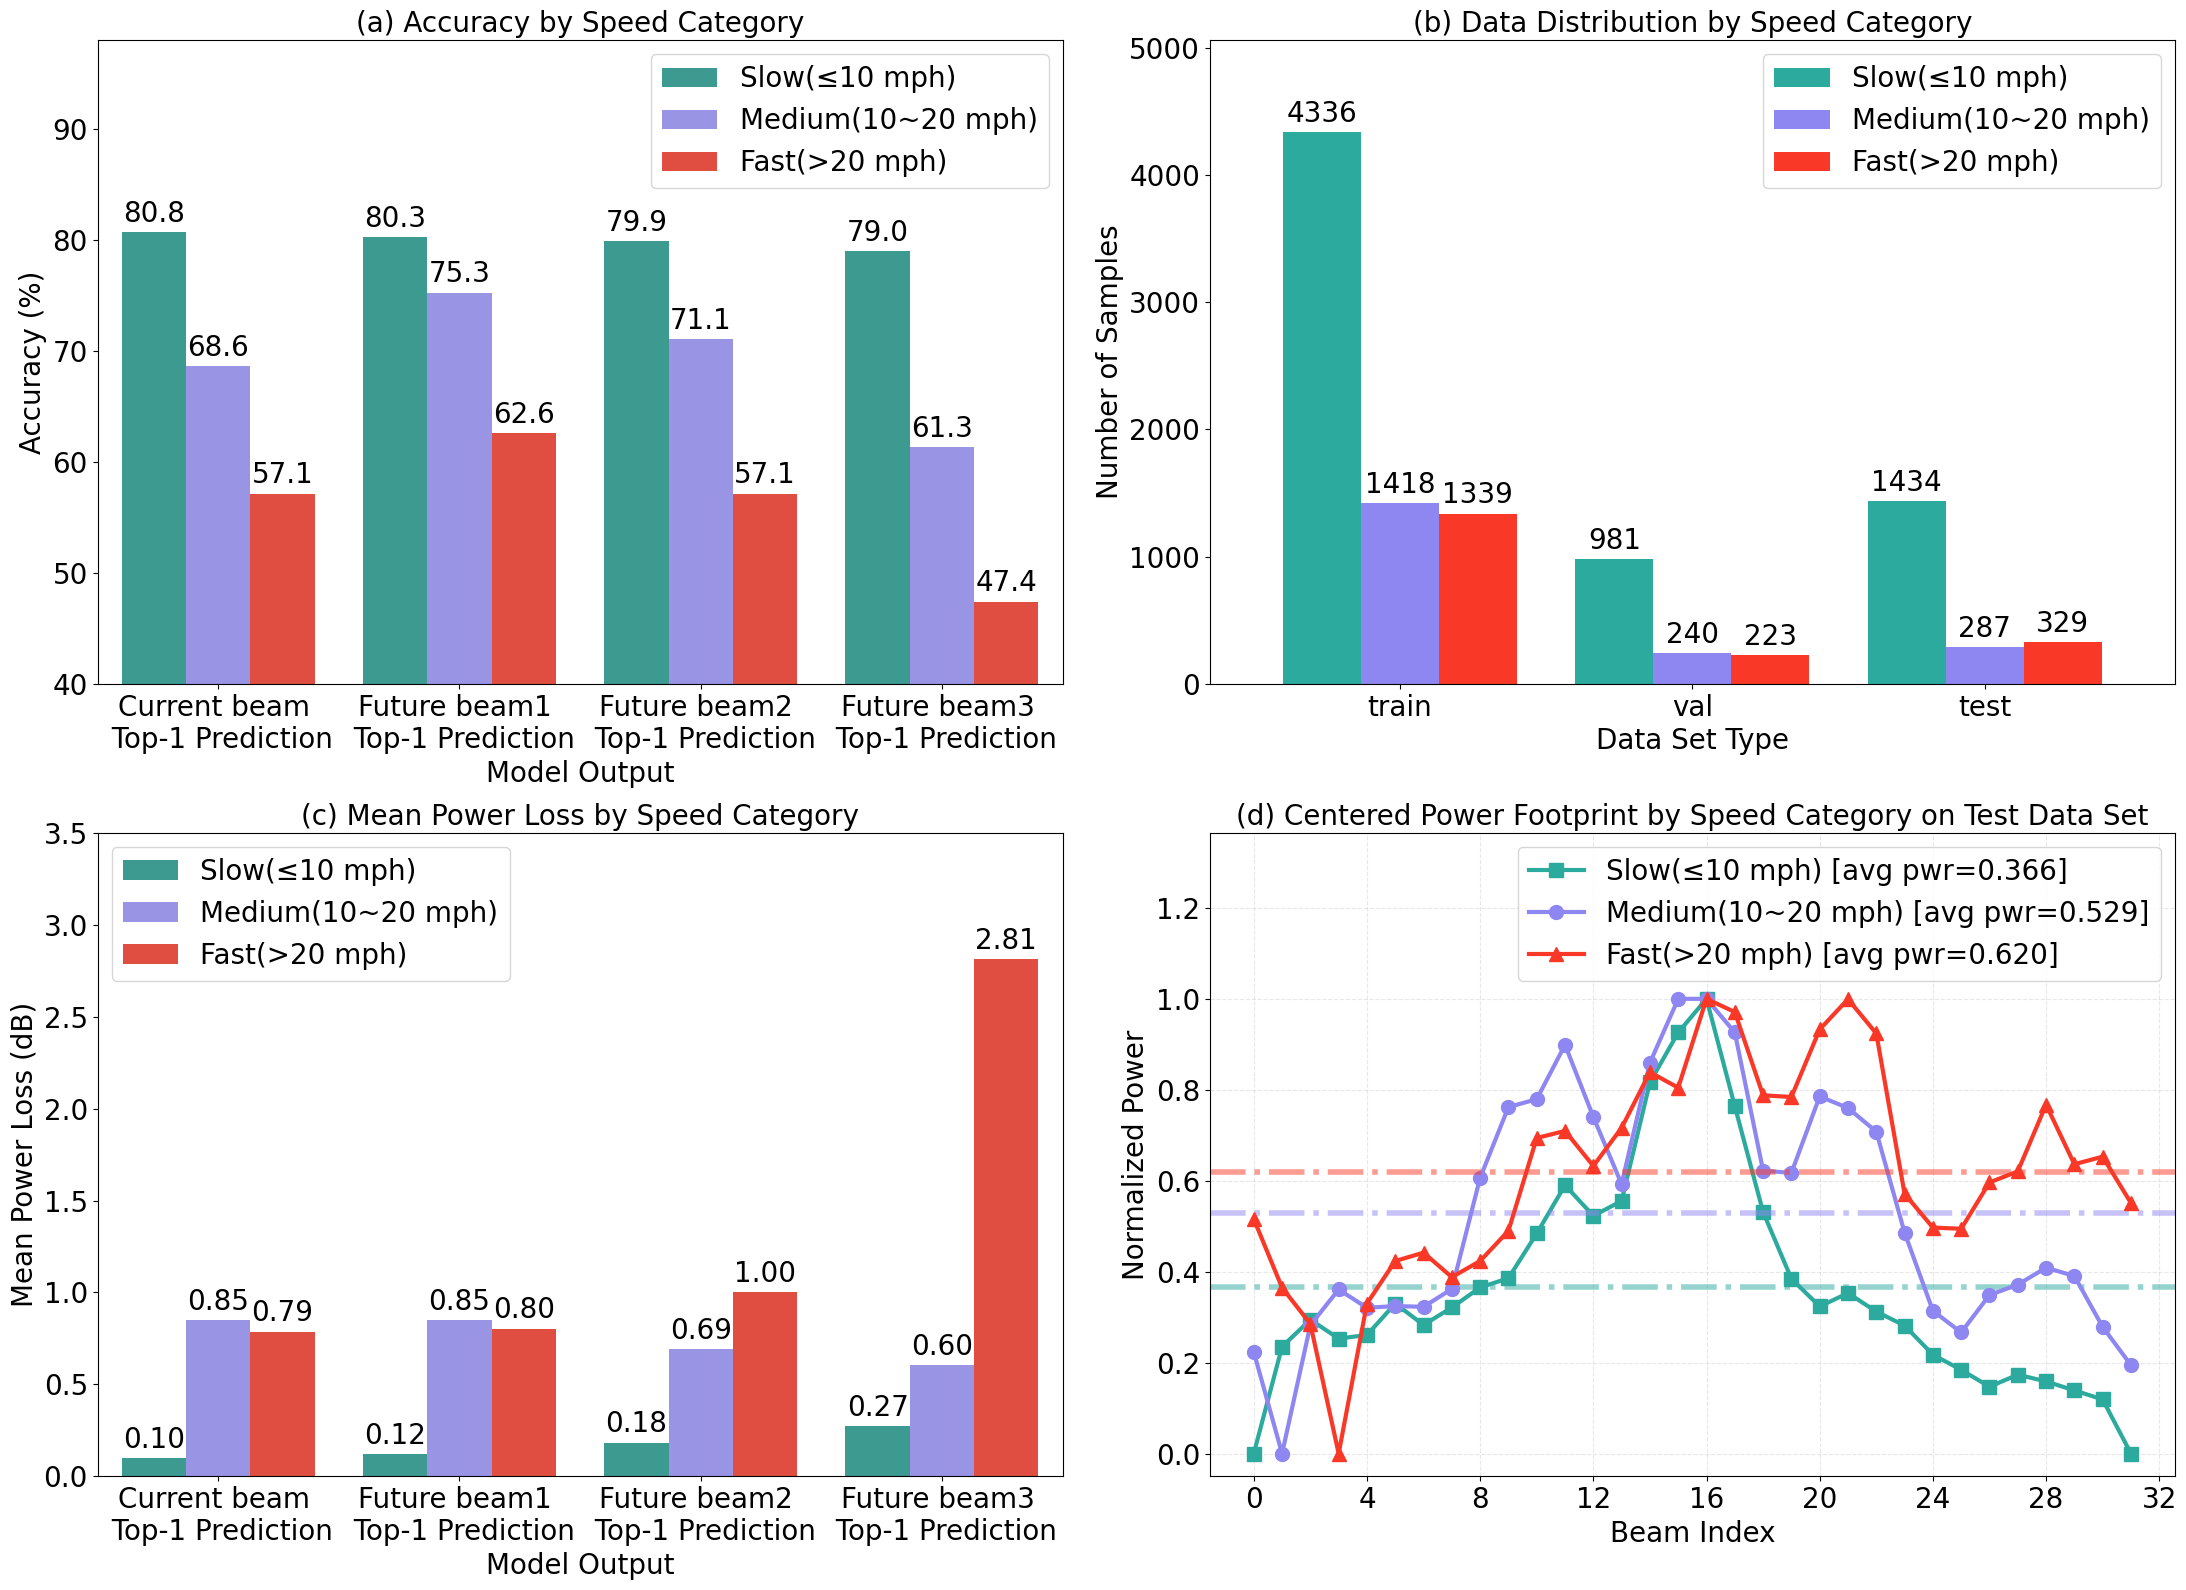

C:\Users\vendi\AppData\Local\Temp\ipykernel_15340\4066020560.py:452: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.3)


saved to F:/repo/gpsbeam/data/experiment_result/00_test_drone_cnn_ed_rnn_experiment_20052025_151107/05-20-2025_15_11_29/dl_generated/model_inference_result/combined_height_analysis.pdf


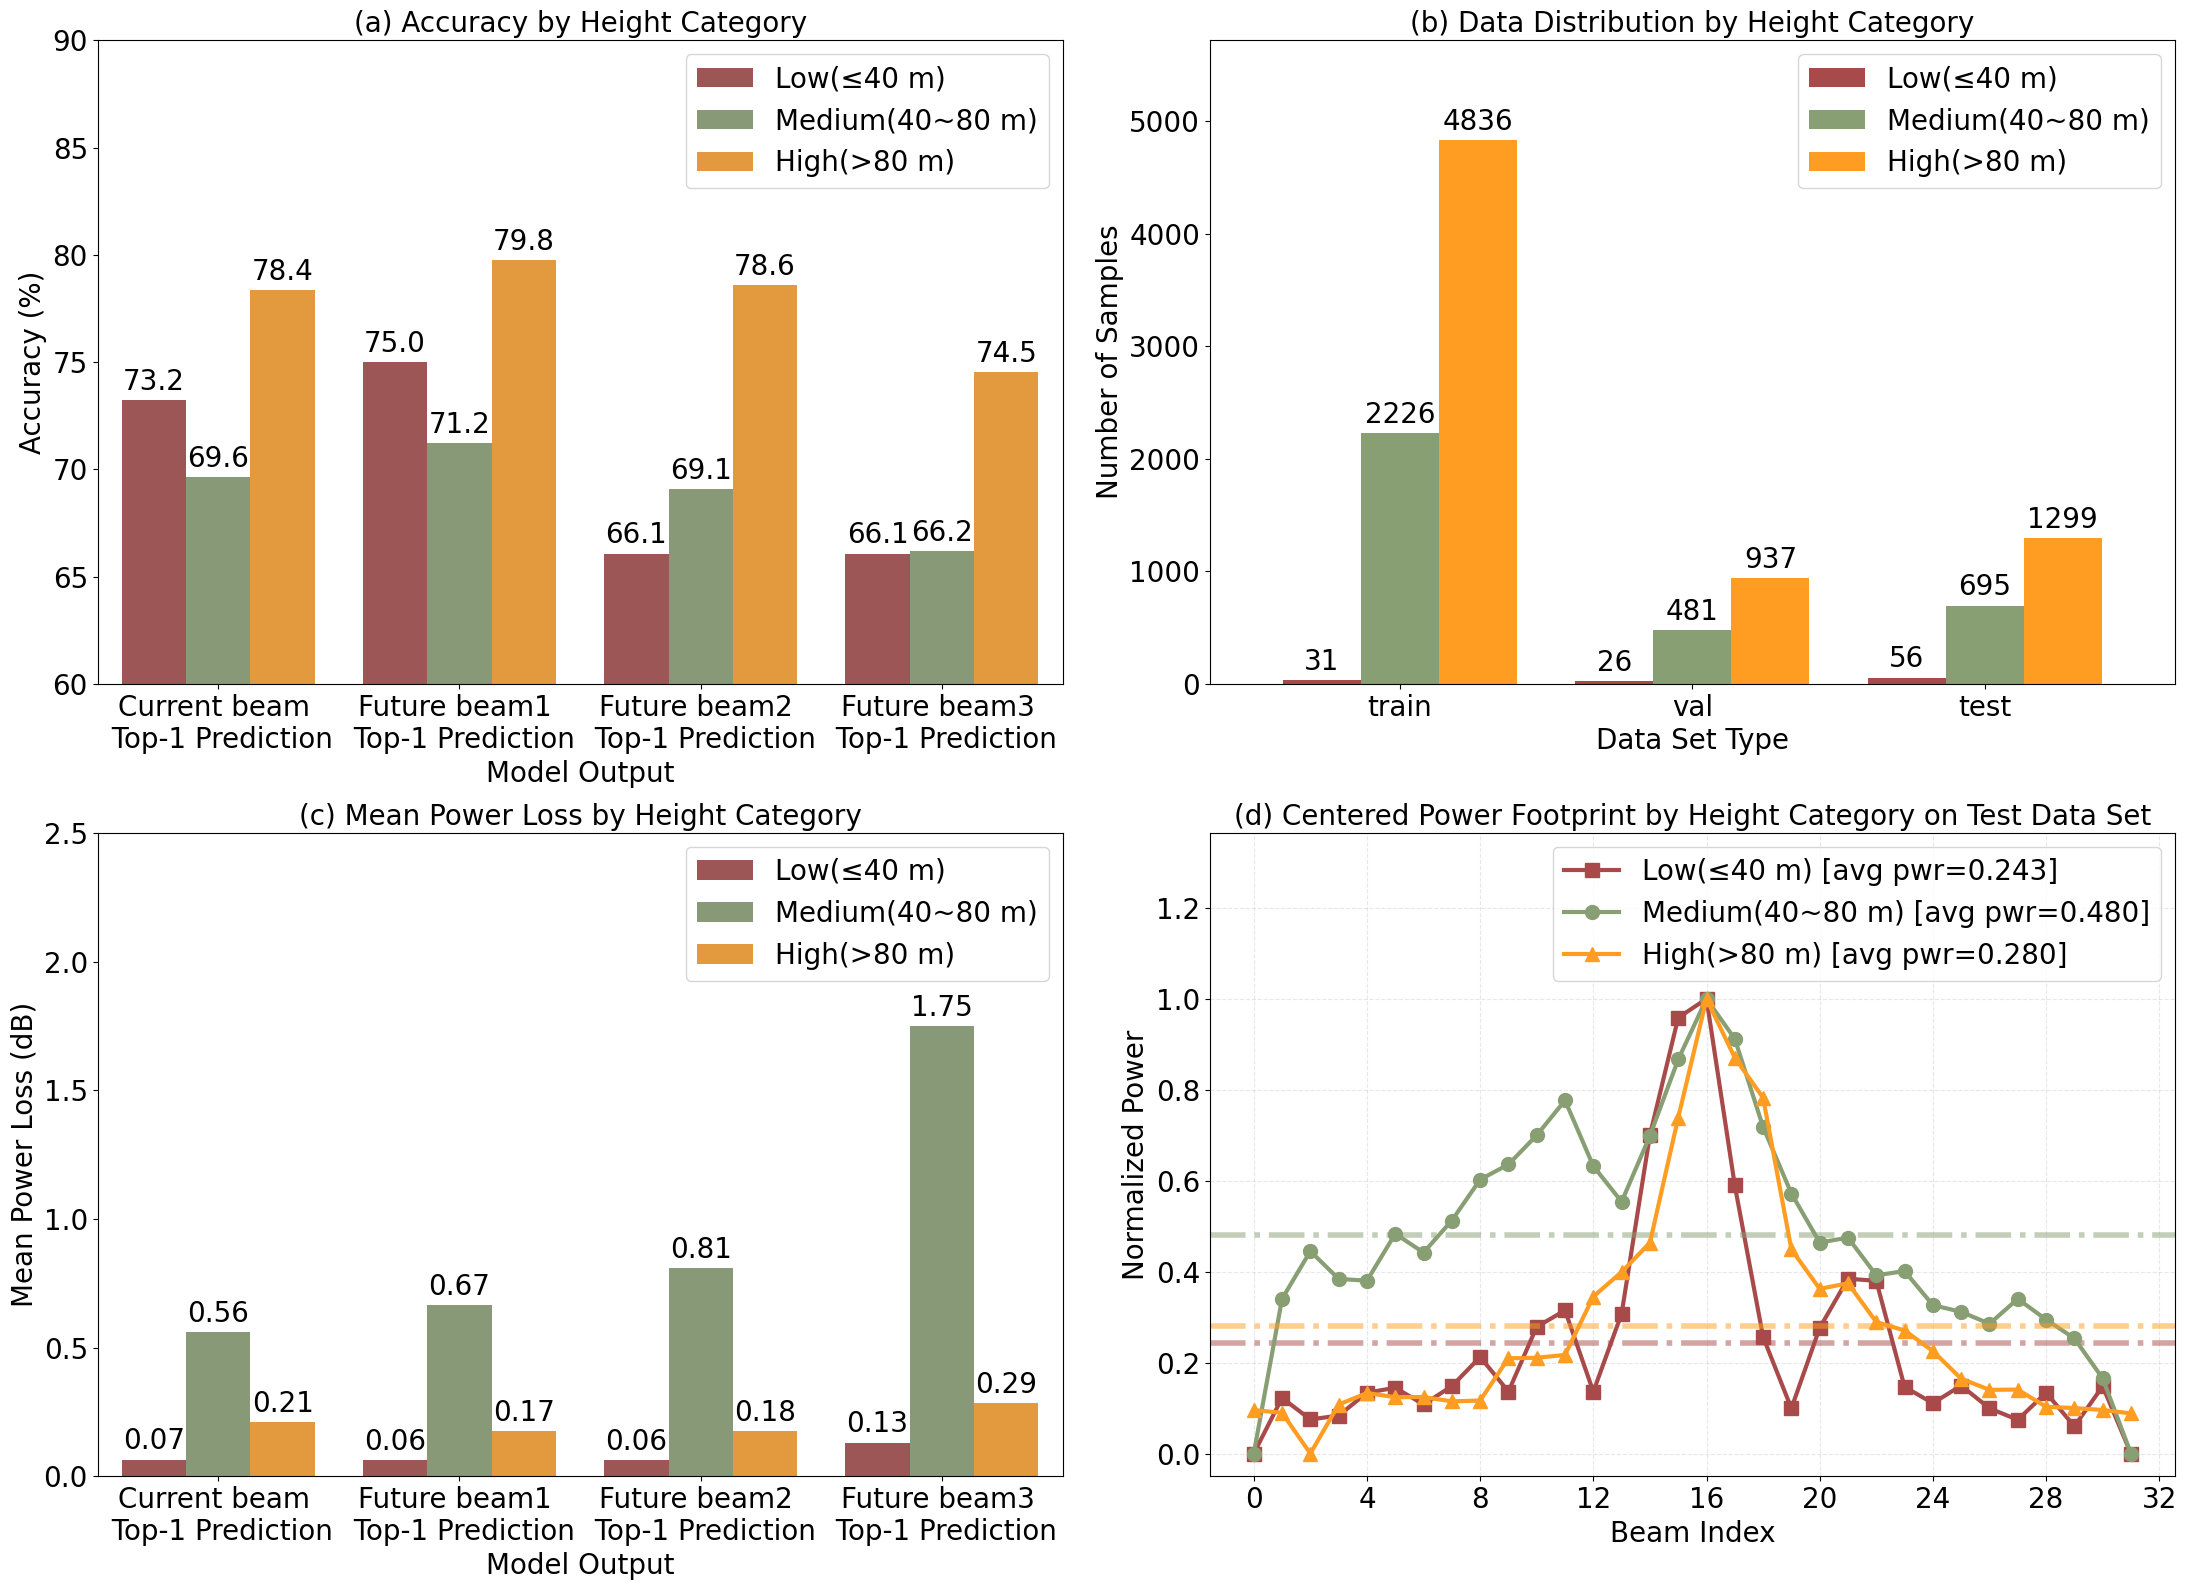

In [11]:
# Generate the plots
# It plot dataset distribution using all_df_tensor as it is the transformed dataset(D_{dev}) that is used for training

# It plot power footprint using test_df_pwrfp_idx, which is derived from the split raw test dataset (D^{test}_{raw}) 
# to prevent sample redundancy. In D_dev, the samples were stored as a sequence. 
# Therefore, between sequencesamples, there may be similar sample indices.

create_combined_analysis_plots(all_df_tensor, df_res, test_df_pwrfp_idx, speed_metrics_df, 
                               'speed', fname, y_min=40, y_max=98, power_loss_y_min=0, 
                               power_loss_y_max=3.5, dist_y_max=4600, scatter_y_max=1.6, 
                               legend_fontsize=20, number_fontsize=20, tick_fontsize=20, 
                               label_fontsize=20, title_fontsize=20)
create_combined_analysis_plots(all_df_tensor, df_res, test_df_pwrfp_idx, height_metrics_df, 
                               'height', fname, y_min=60, y_max=90, power_loss_y_min=0, 
                               power_loss_y_max=2.5, dist_y_max=5200, scatter_y_max=1.6, 
                               legend_fontsize=20, number_fontsize=20, tick_fontsize=20, 
                               label_fontsize=20, title_fontsize=20)


# Combine Plot 2

In [12]:
beamsize_fname = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154421\model_recap\exp_test_result_recap.csv'
df_beam_size = pd.read_csv(beamsize_fname)

fname_8 = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154421\05-20-2025_15_44_43\dl_generated\model_inference_result\test_epoch_00_inference_detail.csv'
fname_16 = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154421\05-20-2025_15_47_03\dl_generated\model_inference_result\test_epoch_00_inference_detail.csv'
fname_32 = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154421\05-20-2025_15_49_13\dl_generated\model_inference_result\test_epoch_00_inference_detail.csv'
fname_64 = r'F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154421\05-20-2025_15_51_33\dl_generated\model_inference_result\test_epoch_00_inference_detail.csv'

df_res_8 = pd.read_csv(fname_8)
df_res_16 = pd.read_csv(fname_16)
df_res_32 = pd.read_csv(fname_32)
df_res_64 = pd.read_csv(fname_64)

dfs_res = [prepare_power_datav2(df) for df in [df_res_8, df_res_16, df_res_32, df_res_64]]

# Create DataConfig and DataPrep objects for each num_classes
data_config_8 = DataConfig(train_val_test_split_frac=train_val_test_split_frac,
                          splitting_method='adjusted',
                          num_classes=8,
                          scenario_num=23)

data_config_16 = DataConfig(train_val_test_split_frac=train_val_test_split_frac,
                           splitting_method='adjusted', 
                           num_classes=16,
                           scenario_num=23)

data_config_32 = DataConfig(train_val_test_split_frac=train_val_test_split_frac,
                           splitting_method='adjusted',
                           num_classes=32, 
                           scenario_num=23)

data_config_64 = DataConfig(train_val_test_split_frac=train_val_test_split_frac,
                           splitting_method='adjusted',
                           num_classes=64,
                           scenario_num=23)

# Create DataPrep objects and get datasets
dataprep_8 = DataPrep(data_config_8)
dataprep_16 = DataPrep(data_config_16) 
dataprep_32 = DataPrep(data_config_32)
dataprep_64 = DataPrep(data_config_64)

# Get train-val-test splits for each
df_8 = dataprep_8.get_train_val_test_dataset()
df_16 = dataprep_16.get_train_val_test_dataset()
df_32 = dataprep_32.get_train_val_test_dataset()
df_64 = dataprep_64.get_train_val_test_dataset()

# Concatenate datasets for each beam size
dfs = []
for dataprep in [dataprep_8, dataprep_16, dataprep_32, dataprep_64]:
    df = concat_train_test(dataprep)
    dfs.append(df)

df_8 = dfs[0]
df_16 = dfs[1] 
df_32 = dfs[2]
df_64 = dfs[3]

# Filter train dataset
train_df_8 = df_8[df_8['dataset'] == 'train']
train_df_16 = df_16[df_16['dataset'] == 'train']
train_df_32 = df_32[df_32['dataset'] == 'train']
train_df_64 = df_64[df_64['dataset'] == 'train']

# Compute entropy for each beam size on train data
train_entropy_8 = compute_entropy(train_df_8, 'unit1_beam_idx_8')
train_entropy_16 = compute_entropy(train_df_16, 'unit1_beam_idx_16')
train_entropy_32 = compute_entropy(train_df_32, 'unit1_beam_idx_32')
train_entropy_64 = compute_entropy(train_df_64, 'unit1_beam_idx_64')


train_df_entropy = pd.DataFrame({
    'num_classes': [8, 16, 32, 64],
    'entropy': [
        compute_entropy(train_df_8, 'unit1_beam_idx_8'),
        compute_entropy(train_df_16, 'unit1_beam_idx_16'), 
        compute_entropy(train_df_32, 'unit1_beam_idx_32'),
        compute_entropy(train_df_64, 'unit1_beam_idx_64')
    ]
})
beam_sizes = [8, 16, 32, 64]


2025-05-20 16:28:18.140 | INFO     | src.data.dataprep:get_train_val_test_dataset:296 - 
Dataset is LOADED from f:/repo/gpsbeam\data/processed/Scenario23/dset_scenario23_seednum42_train0.65_test0.2_portion100_beam8_splitting_method_adjusted.hkl
2025-05-20 16:28:18.140 | INFO     | src.data.dataprep:get_train_val_test_dataset:311 - 
                    RAW DATASET INFO
                    ------------------------------
                    Scenario Num                                    : 23,
                    Splitting Method                                : adjusted
                    Portion Percentage                              : 100
                    Training                                        : 7397 samples [64.96%]
                    Validation                                      : 1704 samples [14.96%]
                    Testing                                         : 2286 samples [20.08%]
                    Total                                           : 11387

saved in F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154421\model_recap\beam_size_dashboard.pdf


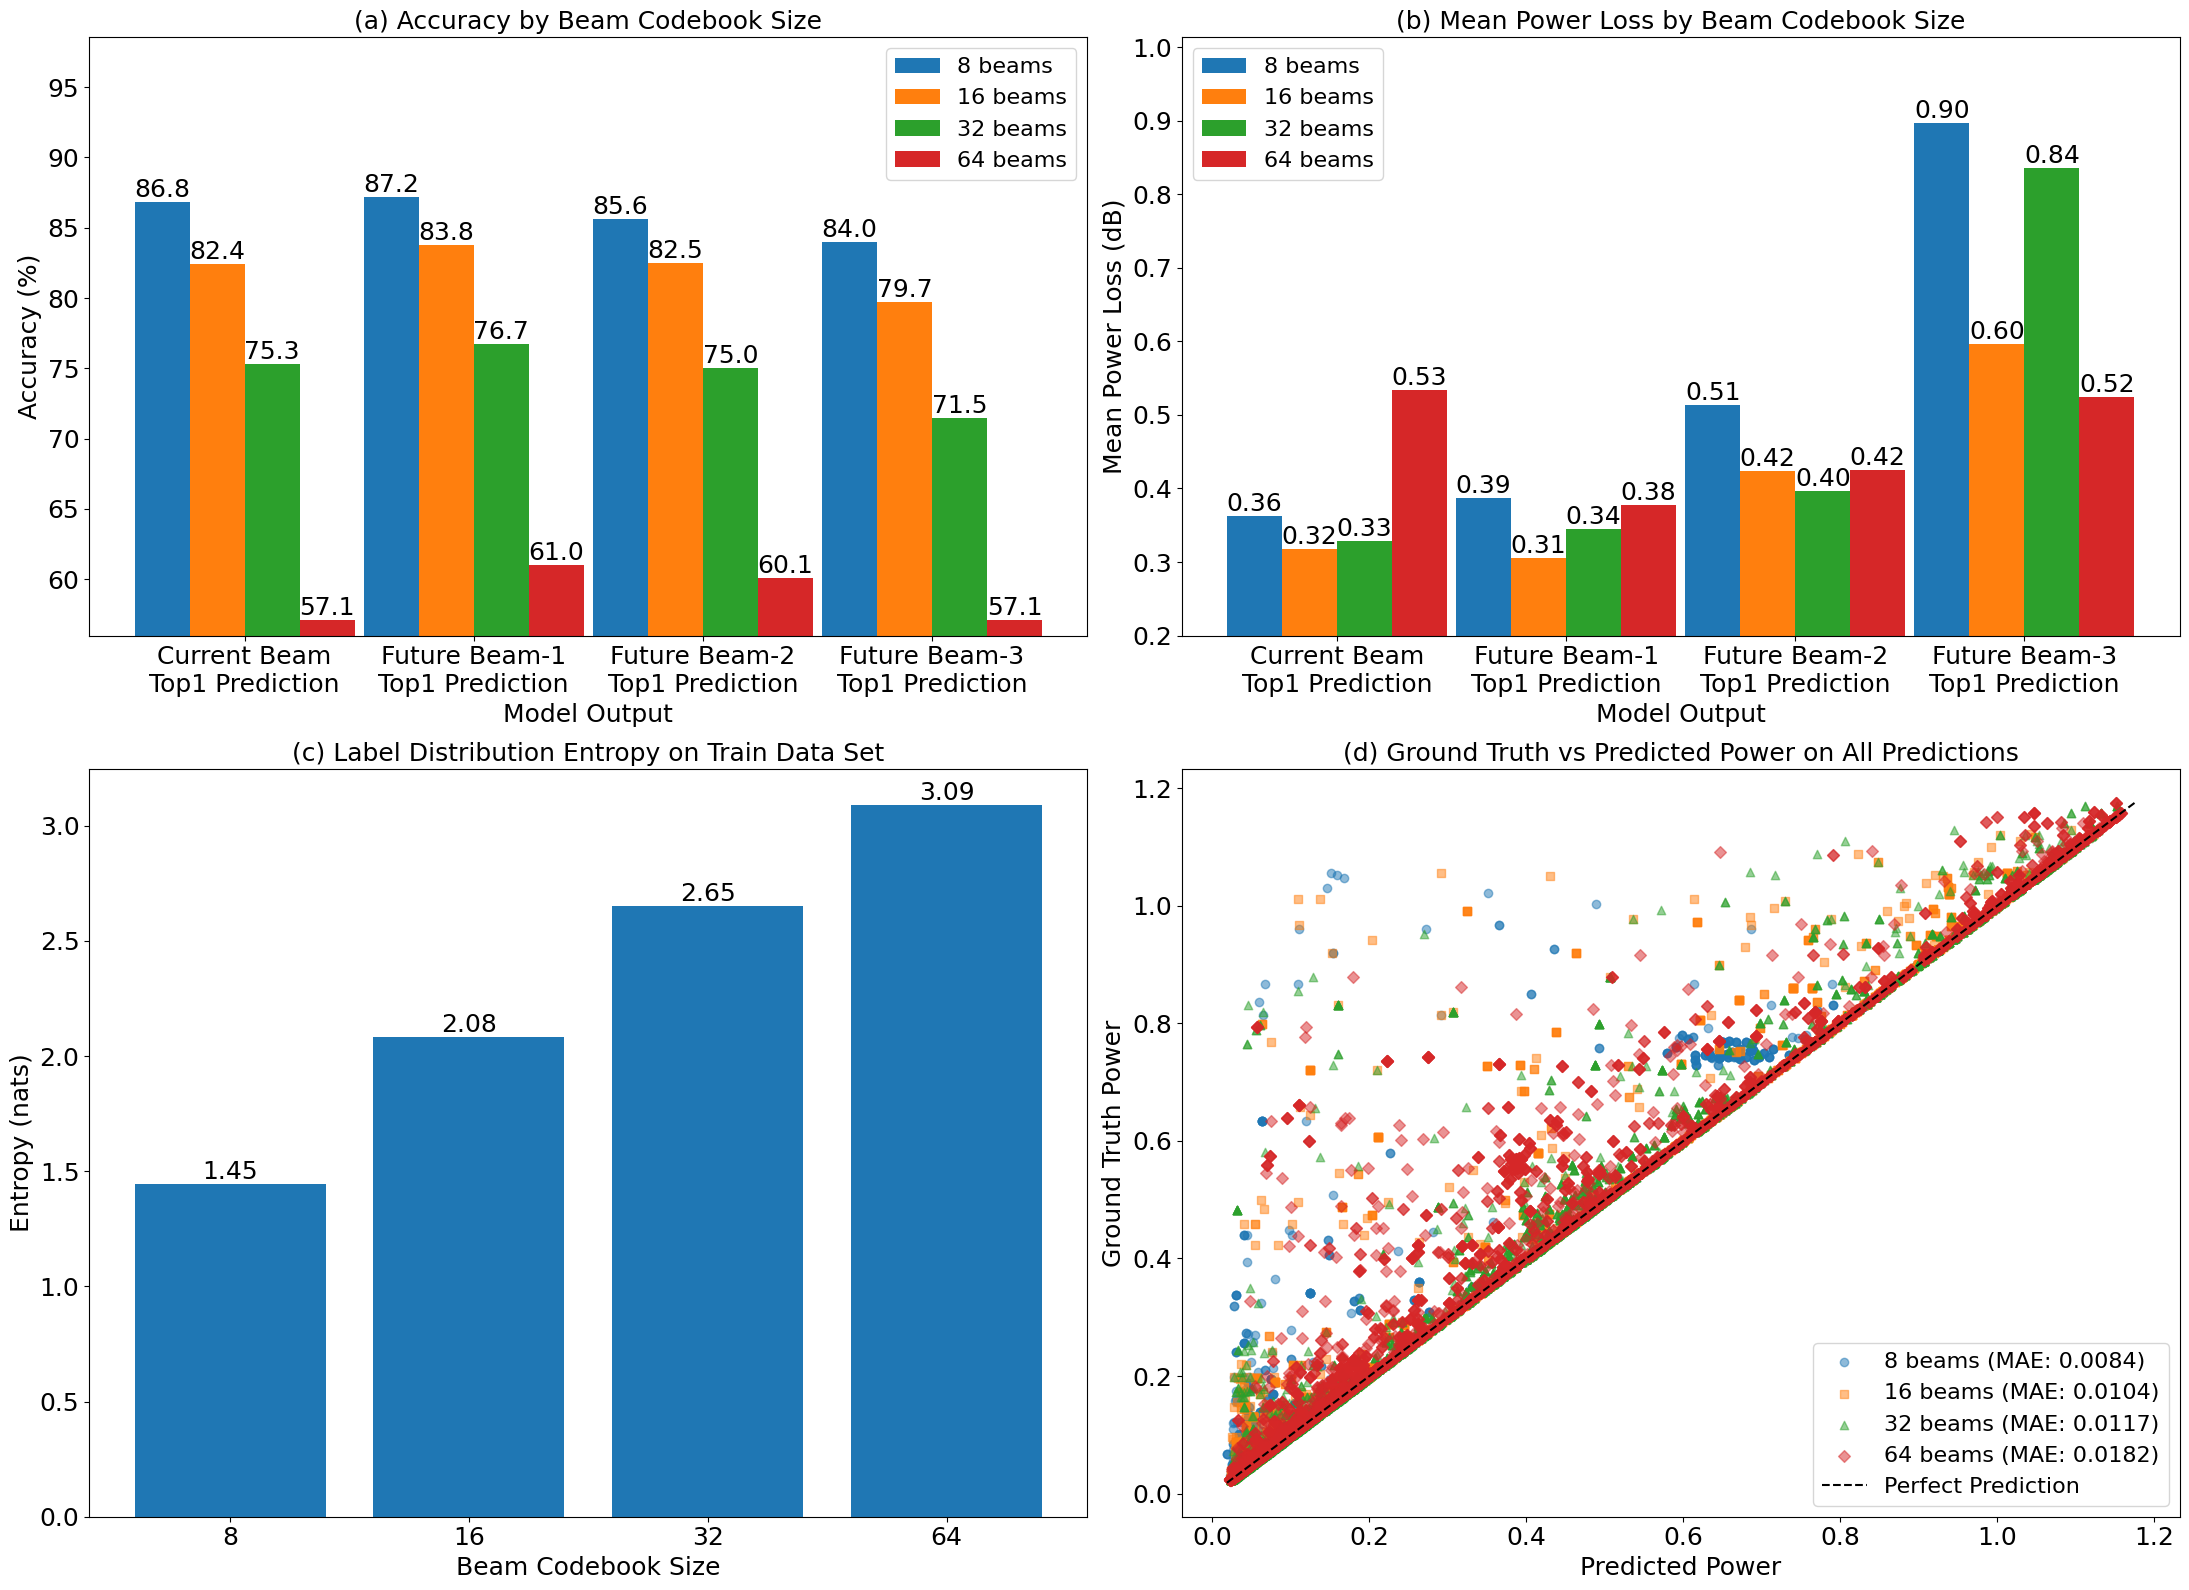

In [13]:
plot_beam_size_comparison(df_beam_size, train_df_entropy,
                          dfs_res, beam_sizes, fname=beamsize_fname,
                          lower_y_loss=0.2, lower_y_acc=56, fig_size=(22,16),
                          dataset_type='train', bar_width=0.24,
                          y_max_multiplier=1.13,

                        # Font sizes for accuracy and power loss plots
                        acc_power_legend_size=16, 
                        acc_power_number_size=18,
                        acc_power_axis_size=18,
                        acc_power_title_size=18,
                        acc_power_tick_size=18,
                        # Font sizes for entropy and scatter plots  
                        other_legend_size=16,
                        other_number_size=18, 
                        other_axis_size=18,
                        other_title_size=18,
                        other_tick_size=18,

                        plot_entropy_and_mae=True
                          )

saved in F:\repo\gpsbeam\data\experiment_result\01_drone_cnn_ed_rnn_experiment_var_num_classes_20052025_154421\model_recap\beam_size_dashboard_no_entropy_mae.pdf


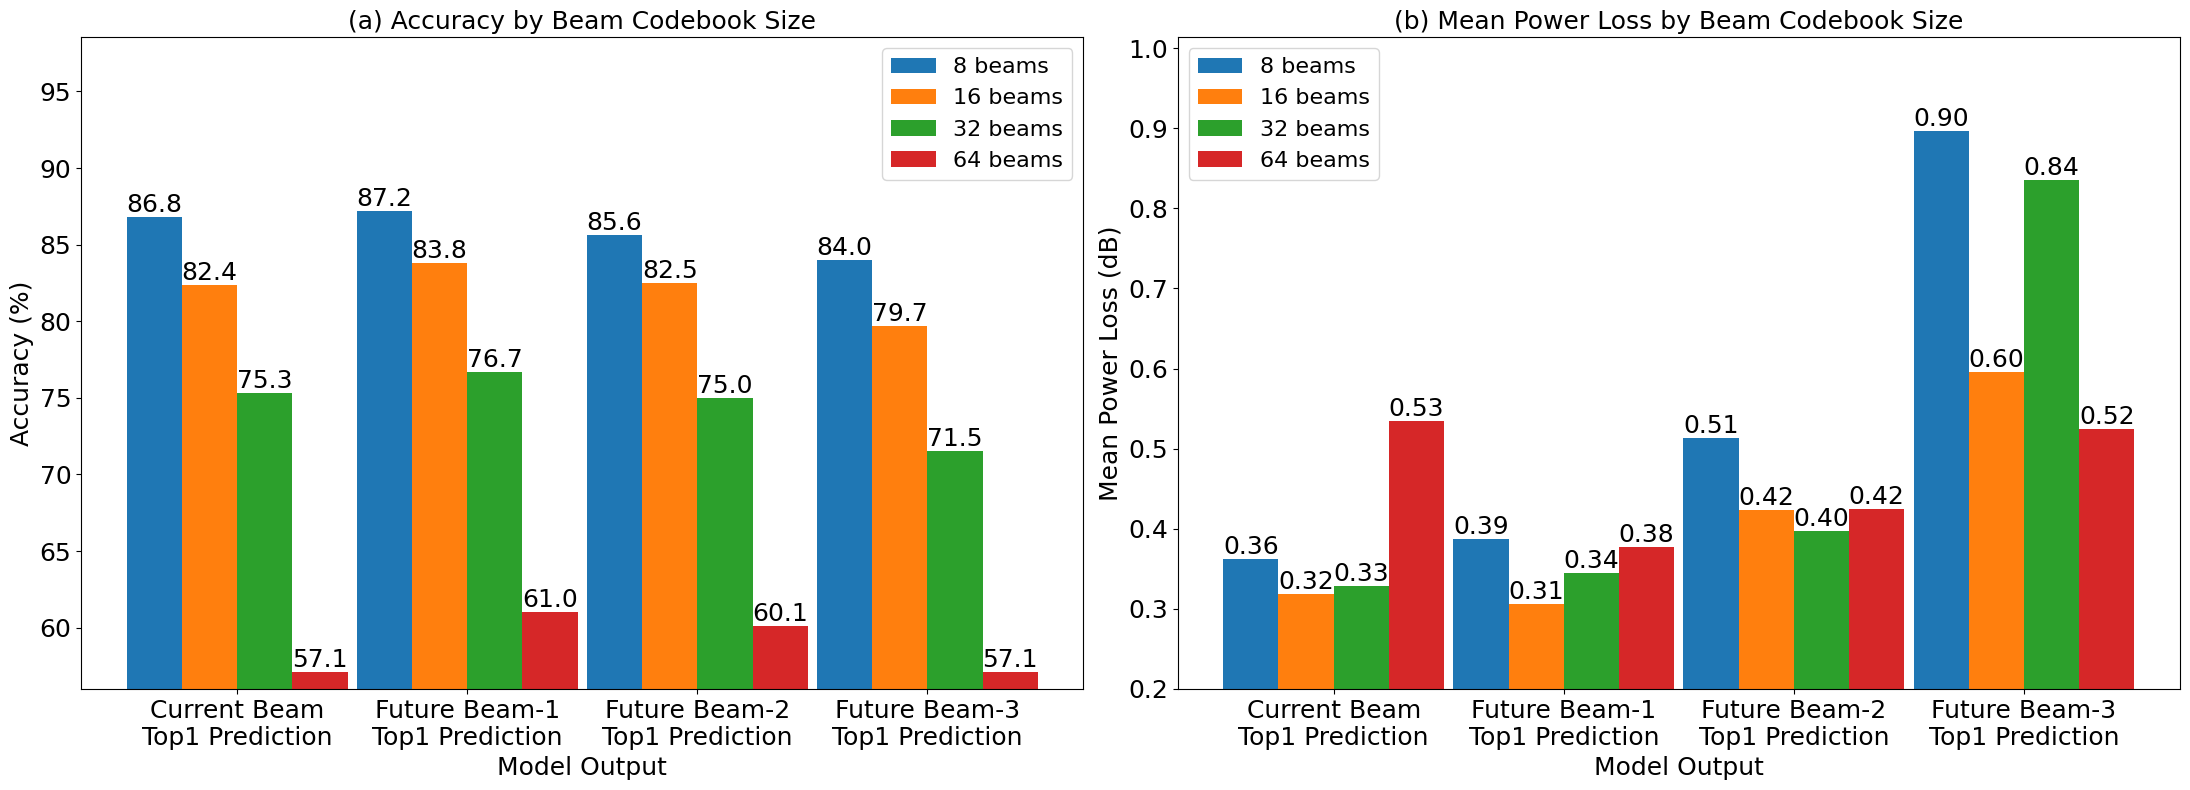

In [14]:
plot_beam_size_comparison(df_beam_size, train_df_entropy,
                          dfs_res, beam_sizes, fname=beamsize_fname,
                          lower_y_loss=0.2, lower_y_acc=56, fig_size=(22,16),
                          dataset_type='train', bar_width=0.24,
                          y_max_multiplier=1.13,

                        # Font sizes for accuracy and power loss plots
                        acc_power_legend_size=16, 
                        acc_power_number_size=18,
                        acc_power_axis_size=18,
                        acc_power_title_size=18,
                        acc_power_tick_size=18,
                        # Font sizes for entropy and scatter plots  
                        other_legend_size=16,
                        other_number_size=18, 
                        other_axis_size=18,
                        other_title_size=18,
                        other_tick_size=18,

                        plot_entropy_and_mae=False
                          )

In [15]:
def get_power_footprint_df(df_all: pd.DataFrame, n_beams: int, max_beams: int = 64) -> pd.DataFrame:
    """
    Get power footprint dataframe for testing data with specified number of beams.
    
    Args:
        df_all (pd.DataFrame): Input dataframe containing all data
        n_beams (int): Number of beams to use
        max_beams (int): Maximum number of beams in original data
        
    Returns:
        pd.DataFrame: DataFrame with power footprint data for specified number of beams
    """
    test_df_pwr_footprint = df_all[df_all['dataset'] == 'test'].copy()
    test_df_pwr_footprint = test_df_pwr_footprint[['unit1_pwr_60ghz']]
    test_df_pwr_footprint['beam_size'] = n_beams
    test_df_pwr_footprint['unit1_pwr_60ghz'] = test_df_pwr_footprint['unit1_pwr_60ghz'].apply(lambda x: np.loadtxt(x))
    
    divider = max_beams // n_beams
    beam_idxs = np.arange(0, max_beams, divider)
    test_df_pwr_footprint['unit1_pwr_60ghz'] = test_df_pwr_footprint['unit1_pwr_60ghz'].apply(lambda x: x[beam_idxs])
    
    return test_df_pwr_footprint

df_pwr_footprint_list = []
for n_beams in [8, 16, 32, 64]:
    test_df_pwr_footprint_beamsize = get_power_footprint_df(df_all, n_beams=n_beams)
    df_pwr_footprint_list.append(test_df_pwr_footprint_beamsize)

df_pwr_beamsize = pd.concat(df_pwr_footprint_list)
df_pwr_beamsize.head(1)


,unit1_pwr_60ghz,beam_size
9081,"[0.02119377, 0.02804588, 0.10860357, 0.08761638, 0.0844065, 0.31141526, 0.17340875, 0.08588014]",8


In [16]:
# Calculate average power per beam size
avg_power_by_beamsize = df_pwr_beamsize.groupby('beam_size').mean().reset_index()
# minmax normalize the power
avg_power_by_beamsize['unit1_pwr_60ghz'] = avg_power_by_beamsize['unit1_pwr_60ghz'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# compute the average power for each beam size
avg_power_by_beamsize['avg_power'] = avg_power_by_beamsize['unit1_pwr_60ghz'].apply(lambda x: np.mean(x))

avg_power_by_beamsize


,beam_size,unit1_pwr_60ghz,avg_power
0,8,"[0.0, 0.2858614895249749, 0.45841598259076655, 0.566231730606283, 1.0, 0.4149605280965322, 0.25807793969397946, 0.2247301216362631]",0.401035
1,16,"[0.0, 0.3209313706360265, 0.2858614895249749, 0.3163759292856406, 0.45841598259076655, 0.5752456886680194, 0.566231730606283, 0.8759718324628479, 1.0, 0.590016090440905, 0.4149605280965322, 0.3591008131919022, 0.25807793969397946, 0.21824858228486516, 0.2247301216362631, 0.15032615496063623]",0.413406
2,32,"[0.0, 0.25488784668193415, 0.3209313706360265, 0.2826405869839365, 0.2858614895249749, 0.34377708886434305, 0.3163759292856406, 0.39826804908808855, 0.45841598259076655, 0.472177046256993, 0.5752456886680194, 0.6452256618824441, 0.566231730606283, 0.6463267636460043, 0.8759718324628479, 0.9517627113368007, 1.0, 0.7737215751470543, 0.590016090440905, 0.49213991180831923, 0.4149605280965322, 0.4256675834423542, 0.3591008131919022, 0.3152669103864252, 0.25807793969397946, 0.2538083711692589, 0.21824858228486516, 0.24643851867924566, 0.2247301216362631, 0.18945248453286478, 0.15032615496063623, 0.15923600991958226]",0.420790
3,64,"[0.0, 0.2382091849489697, 0.25488784668193415, 0.29123758493810875, 0.3209313706360265, 0.3520015753795829, 0.2826405869839365, 0.2553280638958842, 0.2858614895249749, 0.34295682005391065, 0.34377708886434305, 0.31466967952033775, 0.3163759292856406, 0.3333274427422829, 0.39826804908808855, 0.4012163905998215, 0.45841598259076655, 0.43446686706927024, 0.472177046256993, 0.5156207769610197, 0.5752456886680194, 0.593397643040455, 0.6452256618824441, 0.6029023554360475, 0.566231730606283, 0.5919069247020513, 0.6463267636460043, 0.766137872749516, 0.8759718324628479, 0.9239395192035149, 0.9517627113368007, 0.960370505277727, 1.0, 0.9389591009219581, 0.7737215751470543, 0.6647325330374375, 0.590016090440905, 0.5248922067941256, 0.49213991180831923, 0.422588309142462, 0.4149605280965322, 0.3834786642675319, 0.4256675834423542, 0.37772170575832936, 0.3591008131919022, 0.33720319316861286, 0.3152669103864252, 0.33935089496427767, 0.25807793969397946, 0.24944242318412285, 0.2538083711692589, 0.26013244838430494, 0.21824858228486516, 0.24427610831251656, 0.24643851867924566, 0.2569347401199682, 0.2247301216362631, 0.20025259611477372, 0.18945248453286478, 0.15401586023678707, 0.15032615496063623, 0.15057462809836794, 0.15923600991958226, 0.020439820296878162]",0.420437


# Plot Height Distribution

In [17]:
train_val_test_split_frac=[0.65,0.15, 0.2]
data_config_obj = DataConfig(train_val_test_split_frac=train_val_test_split_frac,
                             splitting_method='adjusted',
                             num_classes=32,
                             scenario_num=23)

dataprep_obj = DataPrep(data_config_obj)

dataprep_obj.get_train_val_test_dataset()

# Prepare data
train_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['train'])
val_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['val'])
test_df = dataprep_obj.convert_to_df(dataprep_obj.dataset_dict['test'])

# Add dataset labels
for df, label in [(train_df, 'train'), (val_df, 'val'), (test_df, 'test')]:
    df['dataset'] = label

# Combine datasets
df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)

2025-05-20 16:29:49.709 | INFO     | src.data.dataprep:get_train_val_test_dataset:296 - 
Dataset is LOADED from f:/repo/gpsbeam\data/processed/Scenario23/dset_scenario23_seednum42_train0.65_test0.2_portion100_beam32_splitting_method_adjusted.hkl
2025-05-20 16:29:49.710 | INFO     | src.data.dataprep:get_train_val_test_dataset:311 - 
                    RAW DATASET INFO
                    ------------------------------
                    Scenario Num                                    : 23,
                    Splitting Method                                : adjusted
                    Portion Percentage                              : 100
                    Training                                        : 7387 samples [64.87%]
                    Validation                                      : 1694 samples [14.88%]
                    Testing                                         : 2306 samples [20.25%]
                    Total                                           : 1138

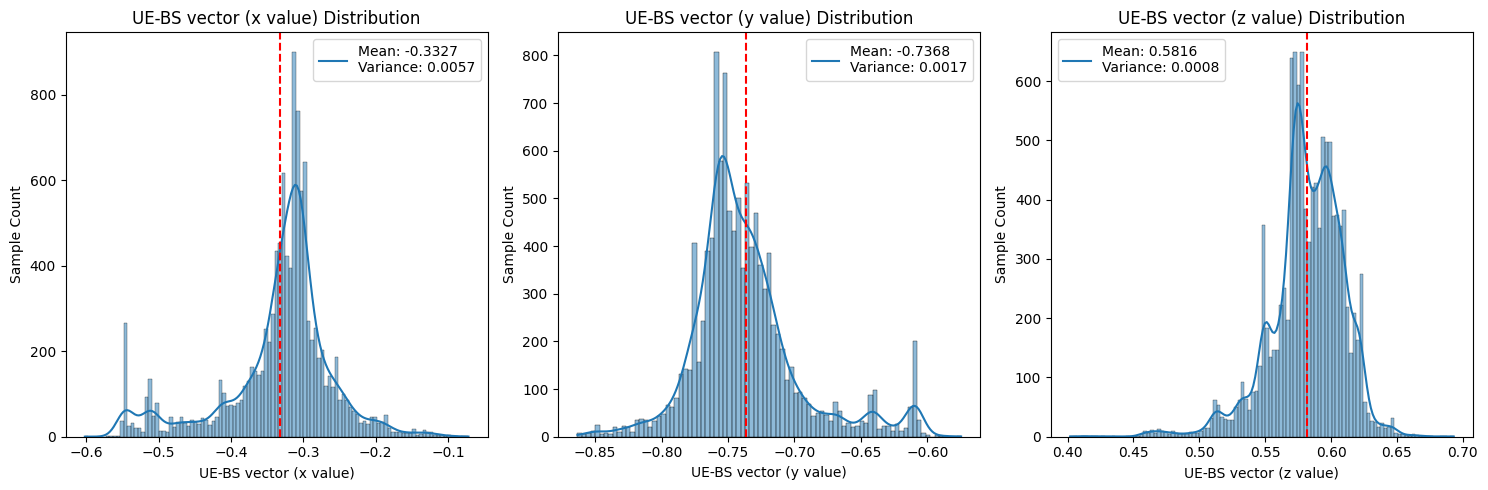

Covariance Matrix:
                        UE-BS vector (x value)  UE-BS vector (y value)  \
UE-BS vector (x value)                0.005737               -0.002675   
UE-BS vector (y value)               -0.002675                0.001709   
UE-BS vector (z value)                0.000360                0.000382   

                        UE-BS vector (z value)  
UE-BS vector (x value)                0.000360  
UE-BS vector (y value)                0.000382  
UE-BS vector (z value)                0.000785  


In [18]:
df_all['UE-BS vector (x value)'] = df_all['unit2to1_vector'].apply(lambda x: x[0])
df_all['UE-BS vector (y value)'] = df_all['unit2to1_vector'].apply(lambda x: x[1])
df_all['UE-BS vector (z value)'] = df_all['unit2to1_vector'].apply(lambda x: x[2])

# Calculate means and covariances
uebs_x_mean = df_all['UE-BS vector (x value)'].mean()
uebs_y_mean = df_all['UE-BS vector (y value)'].mean()
uebs_z_mean = df_all['UE-BS vector (z value)'].mean()

# Calculate covariance matrix
cov_matrix = df_all[['UE-BS vector (x value)', 'UE-BS vector (y value)', 'UE-BS vector (z value)']].cov()

# Create figure for distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle('Unit2to1 Vector Component Distributions', fontsize=16)

# Plot distributions with mean lines and covariance info
for i, col in enumerate(['UE-BS vector (x value)', 'UE-BS vector (y value)', 'UE-BS vector (z value)']):
    mean_val = df_all[col].mean()
    var_val = df_all[col].var()
    
    # Plot histogram
    sns.histplot(df_all[col], kde=True, ax=axes[i])
    
    # Add vertical line for mean
    axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.4f}')
    
    # Add covariance info to legend
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(f'{col}')
    axes[i].set_ylabel('Sample Count')
    axes[i].legend([f'Mean: {mean_val:.4f}\nVariance: {var_val:.4f}'])

plt.tight_layout()
plt.show()

# Print covariance matrix
print("Covariance Matrix:")
print(cov_matrix)


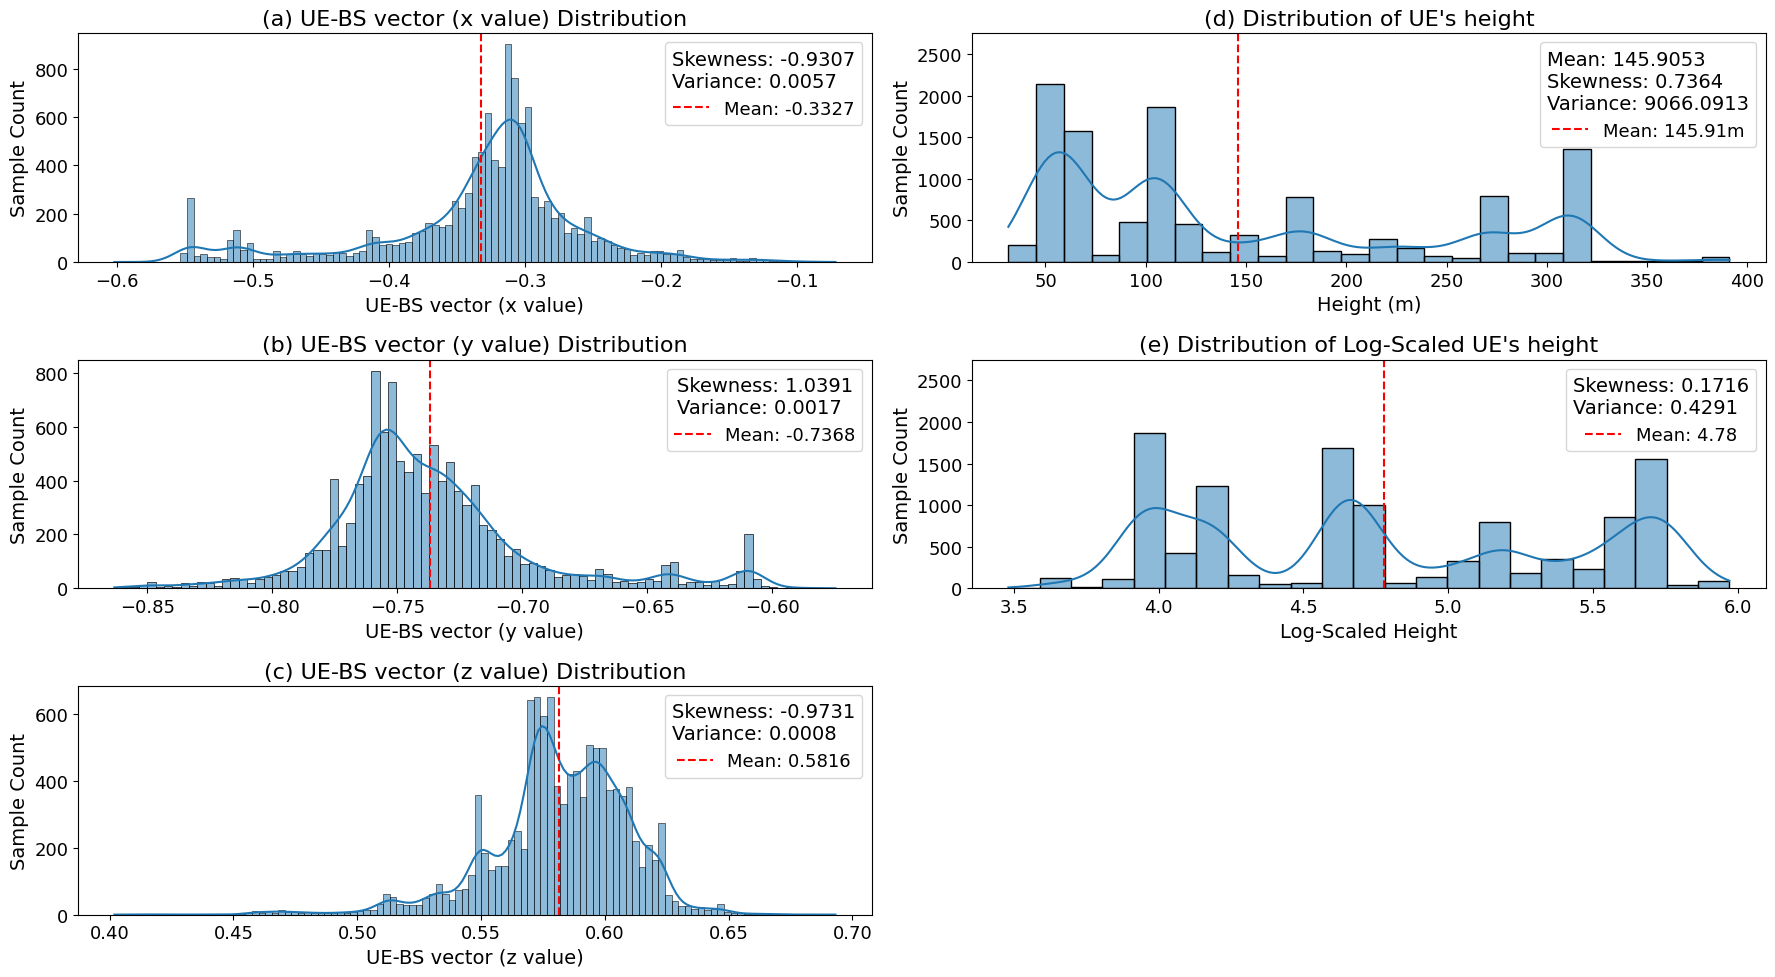

Figure saved to ./combined_distributions.pdf
Covariance Matrix for UE-BS Vector:
                        UE-BS vector (x value)  UE-BS vector (y value)  \
UE-BS vector (x value)                0.005737               -0.002675   
UE-BS vector (y value)               -0.002675                0.001709   
UE-BS vector (z value)                0.000360                0.000382   

                        UE-BS vector (z value)  
UE-BS vector (x value)                0.000360  
UE-BS vector (y value)                0.000382  
UE-BS vector (z value)                0.000785  

Height Statistics:
unit2_height min: 31.496064
unit2_height max: 391.076128
unit2_height_log min: 3.4811189743092554
unit2_height_log max: 5.9714560250169235

Distribution Analysis:
Original Height Mean: 145.9053
Log-Scaled Height Mean: 4.7777
Original Height Skewness: 0.7364
Log-Scaled Height Skewness: 0.1716
Original Height Median: 104.9869
Log-Scaled Height Median: 4.6633

Covariance Analysis:
Original Height Variance:

In [19]:
df_all['UE-BS vector (x value)'] = df_all['unit2to1_vector'].apply(lambda x: x[0])
df_all['UE-BS vector (y value)'] = df_all['unit2to1_vector'].apply(lambda x: x[1])
df_all['UE-BS vector (z value)'] = df_all['unit2to1_vector'].apply(lambda x: x[2])

# Calculate means and covariances
uebs_x_mean = df_all['UE-BS vector (x value)'].mean()
uebs_y_mean = df_all['UE-BS vector (y value)'].mean()
uebs_z_mean = df_all['UE-BS vector (z value)'].mean()

# Calculate covariance matrix
cov_matrix = df_all[['UE-BS vector (x value)', 'UE-BS vector (y value)', 'UE-BS vector (z value)']].cov()

# Calculate skewness for UE-BS vector components
from scipy import stats
uebs_x_skew = stats.skew(df_all['UE-BS vector (x value)'])
uebs_y_skew = stats.skew(df_all['UE-BS vector (y value)'])
uebs_z_skew = stats.skew(df_all['UE-BS vector (z value)'])

# Adjustable parameters
FONT_SIZE = 14  # Adjust this value to change font size
HEIGHT_YLIM = 2750  # Adjust this value to change y-axis limit for height distributions
LOG_HEIGHT_YLIM = 2750  # Adjust this value to change y-axis limit for log height distribution

# Create a single figure with 6 subplots (2 columns, 3 rows)
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

# Set font sizes
plt.rcParams.update({'font.size': FONT_SIZE})

# Plot UE-BS vector distributions in the first three rows, first column
component_names = ['UE-BS vector (x value)', 'UE-BS vector (y value)', 'UE-BS vector (z value)']
for i, col in enumerate(component_names):
    mean_val = df_all[col].mean()
    var_val = df_all[col].var()
    skew_val = stats.skew(df_all[col])
    
    # Plot histogram
    sns.histplot(df_all[col], kde=True, ax=axes[i, 0])
    
    # Add vertical line for mean with label in the legend
    axes[i, 0].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.4f}')
    
    # Add subplot label (a, b, c)
    subplot_label = chr(97 + i)  # 97 is ASCII for 'a'
    
    # Set title and labels
    axes[i, 0].set_title(f'({subplot_label}) {col} Distribution', fontsize=FONT_SIZE+2)
    axes[i, 0].set_xlabel(f'{col}', fontsize=FONT_SIZE)
    axes[i, 0].set_ylabel('Sample Count', fontsize=FONT_SIZE)
    
    # Add legend with the mean line and additional statistics
    axes[i, 0].legend(fontsize=FONT_SIZE-1, title=f'Skewness: {skew_val:.4f}\nVariance: {var_val:.4f}')
    axes[i, 0].tick_params(axis='both', labelsize=FONT_SIZE-1)

# Calculate statistics for height data
from scipy import stats

# Calculate mean, median, variance and skewness for both original and log-scaled height
height_mean = df_all['unit2_height'].mean()
height_log_mean = df_all['unit2_height_log'].mean()
height_skewness = stats.skew(df_all['unit2_height'])
height_log_skewness = stats.skew(df_all['unit2_height_log'])
height_median = df_all['unit2_height'].median()
height_log_median = df_all['unit2_height_log'].median()
height_variance = df_all['unit2_height'].var()
height_log_variance = df_all['unit2_height_log'].var()

# Plot height distribution in the first row, second column
sns.histplot(data=df_all, x='unit2_height', ax=axes[0, 1], kde=True)
axes[0, 1].axvline(x=height_mean, color='red', linestyle='--', label=f'Mean: {height_mean:.2f}m')
axes[0, 1].set_title("(d) Distribution of UE's height", fontsize=FONT_SIZE+2)
axes[0, 1].set_xlabel('Height (m)', fontsize=FONT_SIZE)
axes[0, 1].set_ylabel('Sample Count', fontsize=FONT_SIZE)
axes[0, 1].legend(loc='upper right', title=f"Mean: {height_mean:.4f}\nSkewness: {height_skewness:.4f}\nVariance: {height_variance:.4f}", fontsize=FONT_SIZE-1)
axes[0, 1].set_ylim(0, HEIGHT_YLIM)  # Set y-axis limit for height distribution
axes[0, 1].tick_params(axis='both', labelsize=FONT_SIZE-1)

# Plot log height distribution in the second row, second column
sns.histplot(data=df_all, x='unit2_height_log', ax=axes[1, 1], kde=True)
axes[1, 1].axvline(x=height_log_mean, color='red', linestyle='--', label=f'Mean: {height_log_mean:.2f}')
axes[1, 1].set_title("(e) Distribution of Log-Scaled UE's height", fontsize=FONT_SIZE+2)
axes[1, 1].set_xlabel('Log-Scaled Height', fontsize=FONT_SIZE)
axes[1, 1].set_ylabel('Sample Count', fontsize=FONT_SIZE)
axes[1, 1].legend(loc='upper right', title=f"Skewness: {height_log_skewness:.4f}\nVariance: {height_log_variance:.4f}", fontsize=FONT_SIZE-1)
axes[1, 1].set_ylim(0, LOG_HEIGHT_YLIM)  # Set y-axis limit for log height distribution
axes[1, 1].tick_params(axis='both', labelsize=FONT_SIZE-1)

# Remove the unused subplot
axes[2, 1].axis('off')

plt.tight_layout()

# Save figure to PDF
saved = './combined_distributions.pdf'
plt.savefig(saved)
plt.show()
print(f"Figure saved to {saved}")

# Print statistics
print("Covariance Matrix for UE-BS Vector:")
print(cov_matrix)

print("\nHeight Statistics:")
print("unit2_height min:", df_all['unit2_height'].min())
print("unit2_height max:", df_all['unit2_height'].max())
print("unit2_height_log min:", df_all['unit2_height_log'].min())
print("unit2_height_log max:", df_all['unit2_height_log'].max())

print("\nDistribution Analysis:")
print(f"Original Height Mean: {height_mean:.4f}")
print(f"Log-Scaled Height Mean: {height_log_mean:.4f}")
print(f"Original Height Skewness: {height_skewness:.4f}")
print(f"Log-Scaled Height Skewness: {height_log_skewness:.4f}")
print(f"Original Height Median: {height_median:.4f}")
print(f"Log-Scaled Height Median: {height_log_median:.4f}")

# Calculate covariance
covariance_matrix = df_all[['unit2_height', 'unit2_height_log']].cov()

print("\nCovariance Analysis:")
print(f"Original Height Variance: {height_variance:.4f}")
print(f"Log-Scaled Height Variance: {height_log_variance:.4f}")
print("\nCovariance Matrix for Heights:")
print(covariance_matrix)

# Interpret skewness
def interpret_skewness(skew_value):
    if skew_value > 0.5:
        return "Highly positively skewed (right-tailed)"
    elif skew_value > 0.1:
        return "Moderately positively skewed"
    elif skew_value < -0.5:
        return "Highly negatively skewed (left-tailed)"
    elif skew_value < -0.1:
        return "Moderately negatively skewed"
    else:
        return "Approximately symmetric"

print(f"Original Height Distribution: {interpret_skewness(height_skewness)}")
print(f"Log-Scaled Height Distribution: {interpret_skewness(height_log_skewness)}")

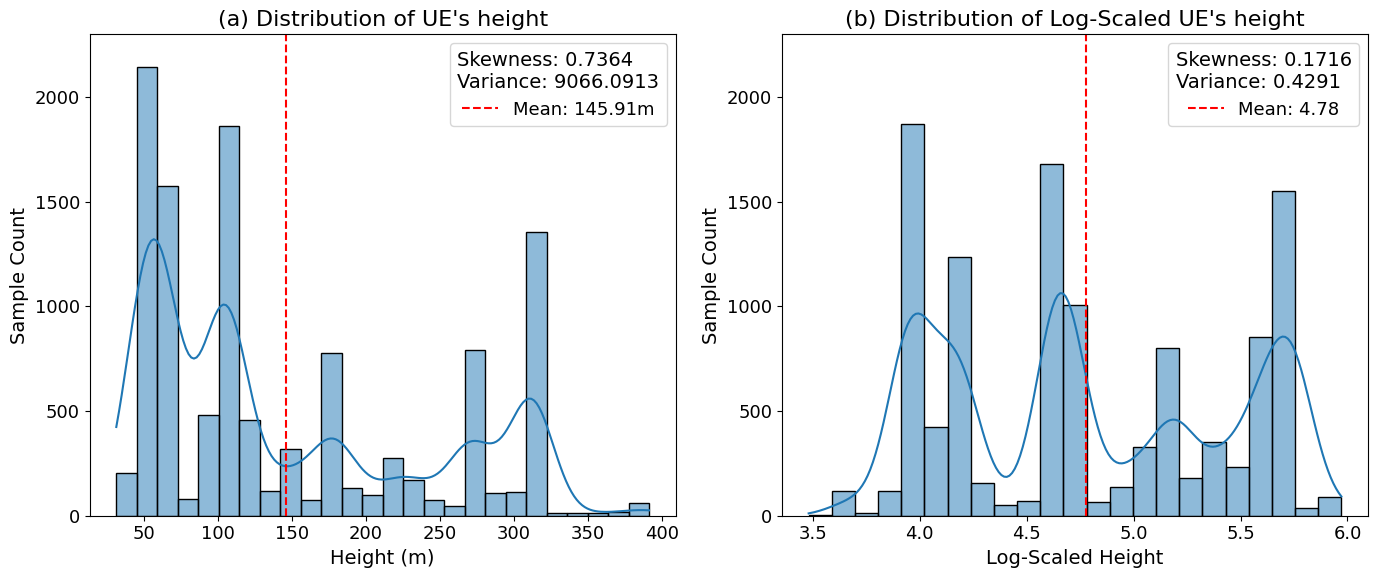

Figure saved to ./height_distributions.pdf

Height Statistics:
unit2_height min: 31.496064
unit2_height max: 391.076128
unit2_height_log min: 3.4811189743092554
unit2_height_log max: 5.9714560250169235

Distribution Analysis:
Original Height Mean: 145.9053
Log-Scaled Height Mean: 4.7777
Original Height Skewness: 0.7364
Log-Scaled Height Skewness: 0.1716
Original Height Median: 104.9869
Log-Scaled Height Median: 4.6633

Covariance Analysis:
Original Height Variance: 9066.0913
Log-Scaled Height Variance: 0.4291

Covariance Matrix for Heights:
                  unit2_height  unit2_height_log
unit2_height       9066.091324         60.520018
unit2_height_log     60.520018          0.429084
Original Height Distribution: Highly positively skewed (right-tailed)
Log-Scaled Height Distribution: Moderately positively skewed


In [20]:
# Calculate statistics for height data
from scipy import stats

# Calculate mean, median, variance and skewness for both original and log-scaled height
height_mean = df_all['unit2_height'].mean()
height_log_mean = df_all['unit2_height_log'].mean()
height_skewness = stats.skew(df_all['unit2_height'])
height_log_skewness = stats.skew(df_all['unit2_height_log'])
height_median = df_all['unit2_height'].median()
height_log_median = df_all['unit2_height_log'].median()
height_variance = df_all['unit2_height'].var()
height_log_variance = df_all['unit2_height_log'].var()

# Adjustable parameters
FONT_SIZE = 14  # Adjust this value to change font size
HEIGHT_YLIM = 2300  # Adjust this value to change y-axis limit for height distributions
LOG_HEIGHT_YLIM = 2300  # Adjust this value to change y-axis limit for log height distribution

# Create a figure with 2 subplots (2 columns, 1 row)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Set font sizes
plt.rcParams.update({'font.size': FONT_SIZE})

# Plot height distribution in the first column
sns.histplot(data=df_all, x='unit2_height', ax=axes[0], kde=True)
axes[0].axvline(x=height_mean, color='red', linestyle='--', label=f'Mean: {height_mean:.2f}m')
axes[0].set_title("(a) Distribution of UE's height", fontsize=FONT_SIZE+2)
axes[0].set_xlabel('Height (m)', fontsize=FONT_SIZE)
axes[0].set_ylabel('Sample Count', fontsize=FONT_SIZE)
axes[0].legend(loc='upper right', title=f"Skewness: {height_skewness:.4f}\nVariance: {height_variance:.4f}", fontsize=FONT_SIZE-1)
axes[0].set_ylim(0, HEIGHT_YLIM)  # Set y-axis limit for height distribution
axes[0].tick_params(axis='both', labelsize=FONT_SIZE-1)

# Plot log height distribution in the second column
sns.histplot(data=df_all, x='unit2_height_log', ax=axes[1], kde=True)
axes[1].axvline(x=height_log_mean, color='red', linestyle='--', label=f'Mean: {height_log_mean:.2f}')
axes[1].set_title("(b) Distribution of Log-Scaled UE's height", fontsize=FONT_SIZE+2)
axes[1].set_xlabel('Log-Scaled Height', fontsize=FONT_SIZE)
axes[1].set_ylabel('Sample Count', fontsize=FONT_SIZE)
axes[1].legend(loc='upper right', title=f"Skewness: {height_log_skewness:.4f}\nVariance: {height_log_variance:.4f}", fontsize=FONT_SIZE-1)
axes[1].set_ylim(0, LOG_HEIGHT_YLIM)  # Set y-axis limit for log height distribution
axes[1].tick_params(axis='both', labelsize=FONT_SIZE-1)

plt.tight_layout()

# Save figure to PDF
saved = './height_distributions.pdf'
plt.savefig(saved)
plt.show()
print(f"Figure saved to {saved}")

# Print statistics
print("\nHeight Statistics:")
print("unit2_height min:", df_all['unit2_height'].min())
print("unit2_height max:", df_all['unit2_height'].max())
print("unit2_height_log min:", df_all['unit2_height_log'].min())
print("unit2_height_log max:", df_all['unit2_height_log'].max())

print("\nDistribution Analysis:")
print(f"Original Height Mean: {height_mean:.4f}")
print(f"Log-Scaled Height Mean: {height_log_mean:.4f}")
print(f"Original Height Skewness: {height_skewness:.4f}")
print(f"Log-Scaled Height Skewness: {height_log_skewness:.4f}")
print(f"Original Height Median: {height_median:.4f}")
print(f"Log-Scaled Height Median: {height_log_median:.4f}")

# Calculate covariance
covariance_matrix = df_all[['unit2_height', 'unit2_height_log']].cov()

print("\nCovariance Analysis:")
print(f"Original Height Variance: {height_variance:.4f}")
print(f"Log-Scaled Height Variance: {height_log_variance:.4f}")
print("\nCovariance Matrix for Heights:")
print(covariance_matrix)

# Interpret skewness
def interpret_skewness(skew_value):
    if skew_value > 0.5:
        return "Highly positively skewed (right-tailed)"
    elif skew_value > 0.1:
        return "Moderately positively skewed"
    elif skew_value < -0.5:
        return "Highly negatively skewed (left-tailed)"
    elif skew_value < -0.1:
        return "Moderately negatively skewed"
    else:
        return "Approximately symmetric"

print(f"Original Height Distribution: {interpret_skewness(height_skewness)}")
print(f"Log-Scaled Height Distribution: {interpret_skewness(height_log_skewness)}")